# Face-based Depression Detection Model

In [ ]:

from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from models.face_strnn import FaceSTRNN
from preprocessing.loader_face import FaceLoader
from preprocessing.loader_results import ResultsLoader
from training.trainer_face_strnn import FaceSTRNNTrainer

# Constants
RANDOM_STATE = 42
DATA_PERCENTAGE = 0.05  # Percentage of total data to use
BATCH_SIZE = 32
N_EPOCHS = 50
FIGURE_SIZE = (15, 8)

# Hyperparameter grid for model tuning
PARAM_GRID = {
    'hidden_size': [64, 128, 256],
    'num_layers': [1, 2],
    'dropout': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.0001],
    'weight_decay': [0.0001, 0.00001]
}

# Device configuration
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: mps


## Data Preparation

In [4]:
def load_data(percentage: float = DATA_PERCENTAGE, random_state: int = RANDOM_STATE) -> Tuple[
    pd.DataFrame, pd.DataFrame]:
    #Load and prepare the facial features data and depression labels.
    # Initialize loaders
    results_loader = ResultsLoader()
    face_loader = FaceLoader()

    # Load data
    df_result = results_loader.get_data(percentage=percentage, random_state=random_state)
    df_face = face_loader.get_data(
        percentage=percentage,
        random_state=random_state,
        ds_freq="10s",
        rw_size="10s"
    )

    return df_face, df_result


# Load the data
df_face, df_result = load_data()

# Display data overview
print("Facial Features:")
display(df_face.head())
print("\nDepression Labels:")
display(df_result.head())

Facial Features:


CLNFgaze_frame  CLNFgaze_confidence  CLNFgaze_success  \
ID  TIMESTAMP                                                                
384 0 days 00:00:00           150.5             0.822928          0.853333   
    0 days 00:00:10           450.5             0.942345          1.000000   
    0 days 00:00:20           750.5             0.795415          0.826667   
    0 days 00:00:30          1050.5             0.935436          1.000000   
    0 days 00:00:40          1350.5             0.905495          1.000000   

                     CLNFgaze_x_0  CLNFgaze_y_0  CLNFgaze_z_0  CLNFgaze_x_1  \
ID  TIMESTAMP                                                                 
384 0 days 00:00:00      0.019377      0.105948     -0.988947     -0.168088   
    0 days 00:00:10      0.012881      0.171094     -0.983179     -0.215756   
    0 days 00:00:20      0.044621      0.140580     -0.983856     -0.162895   
    0 days 00:00:30      0.037770      0.142061     -0.985050     -0.199734   
    0 days 00:00:40      0.055118      0.143783     -0.986932     -0.202850   

                     CLNFgaze_y_1  CLNFgaze_z_1  CLNFgaze_x_h0  ...  \
ID  TIMESTAMP                                                   ...   
384 0 days 00:00:00      0.168538     -0.963268       0.041903  ...   
    0 days 00:00:10      0.228128     -0.947790       0.056247  ...   
    0 days 00:00:20      0.182659     -0.961828       0.025397  ...   
    0 days 00:00:30      0.168713     -0.962383       0.108119  ...   
    0 days 00:00:40      0.197263     -0.958257       0.037995  ...   

                     CLNFfeatures3D_Z58  CLNFfeatures3D_Z59  \
ID  TIMESTAMP                                                 
384 0 days 00:00:00          465.848793          473.215420   
    0 days 00:00:10          464.198243          472.334097   
    0 days 00:00:20          560.372003          569.625170   
    0 days 00:00:30          478.669183          486.468370   
    0 days 00:00:40          477.595643          487.829740   

                     CLNFfeatures3D_Z60  CLNFfeatures3D_Z61  \
ID  TIMESTAMP                                                 
384 0 days 00:00:00          484.276550          467.971497   
    0 days 00:00:10          484.704393          466.092203   
    0 days 00:00:20          583.722400          564.522337   
    0 days 00:00:30          498.751773          481.171780   
    0 days 00:00:40          503.221873          482.282430   

                     CLNFfeatures3D_Z62  CLNFfeatures3D_Z63  \
ID  TIMESTAMP                                                 
384 0 days 00:00:00          467.006567          469.369827   
    0 days 00:00:10          465.115117          467.407627   
    0 days 00:00:20          563.508563          566.368517   
    0 days 00:00:30          480.525857          483.412123   
    0 days 00:00:40          480.941960          483.591137   

                     CLNFfeatures3D_Z64  CLNFfeatures3D_Z65  \
ID  TIMESTAMP                                                 
384 0 days 00:00:00          485.028940          468.755030   
    0 days 00:00:10          484.344507          466.484547   
    0 days 00:00:20          584.090657          564.459013   
    0 days 00:00:30          499.907573          482.457810   
    0 days 00:00:40          500.771017          481.222473   

                     CLNFfeatures3D_Z66  CLNFfeatures3D_Z67  
ID  TIMESTAMP                                                
384 0 days 00:00:00          466.330270          467.754270  
    0 days 00:00:10          464.054117          465.630513  
    0 days 00:00:20          561.682167          563.413037  
    0 days 00:00:30          479.640853          480.904157  
    0 days 00:00:40          478.588557          480.680533  

[5 rows x 4858 columns]


Depression Labels:


,PHQ_Binary
ID,
386,1
388,1
476,0
391,0
452,0


## Exploratory Data Analysis

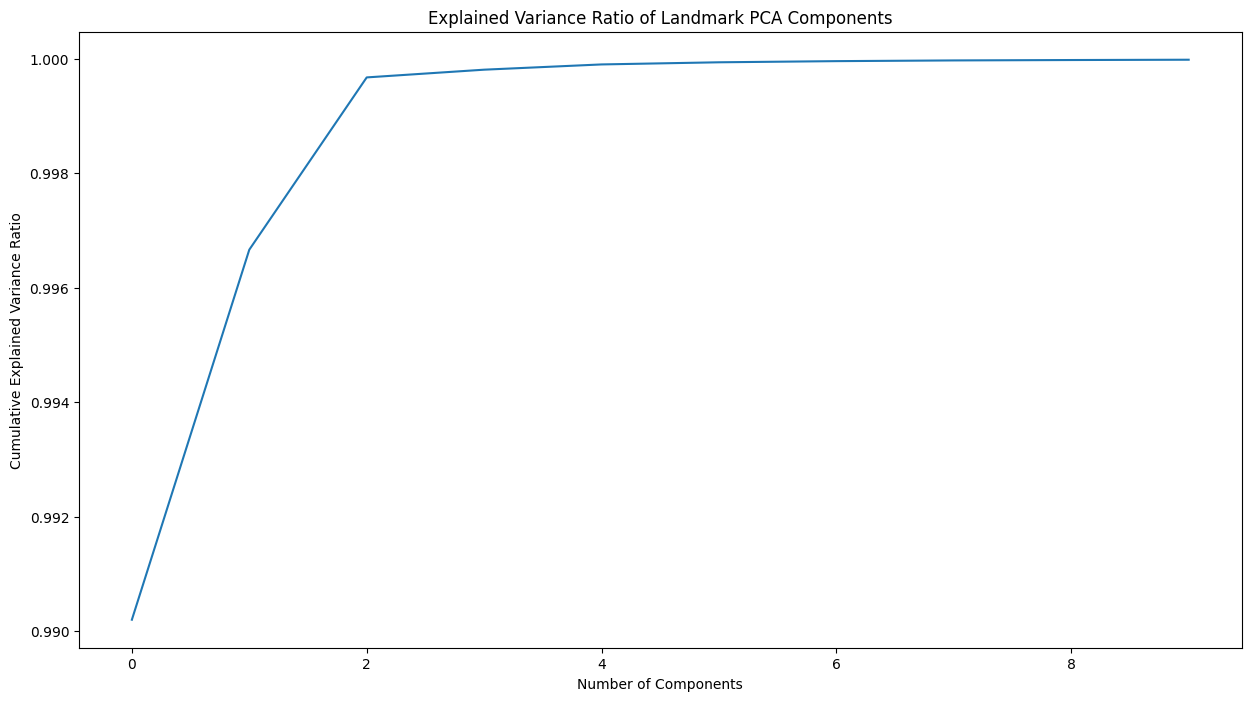

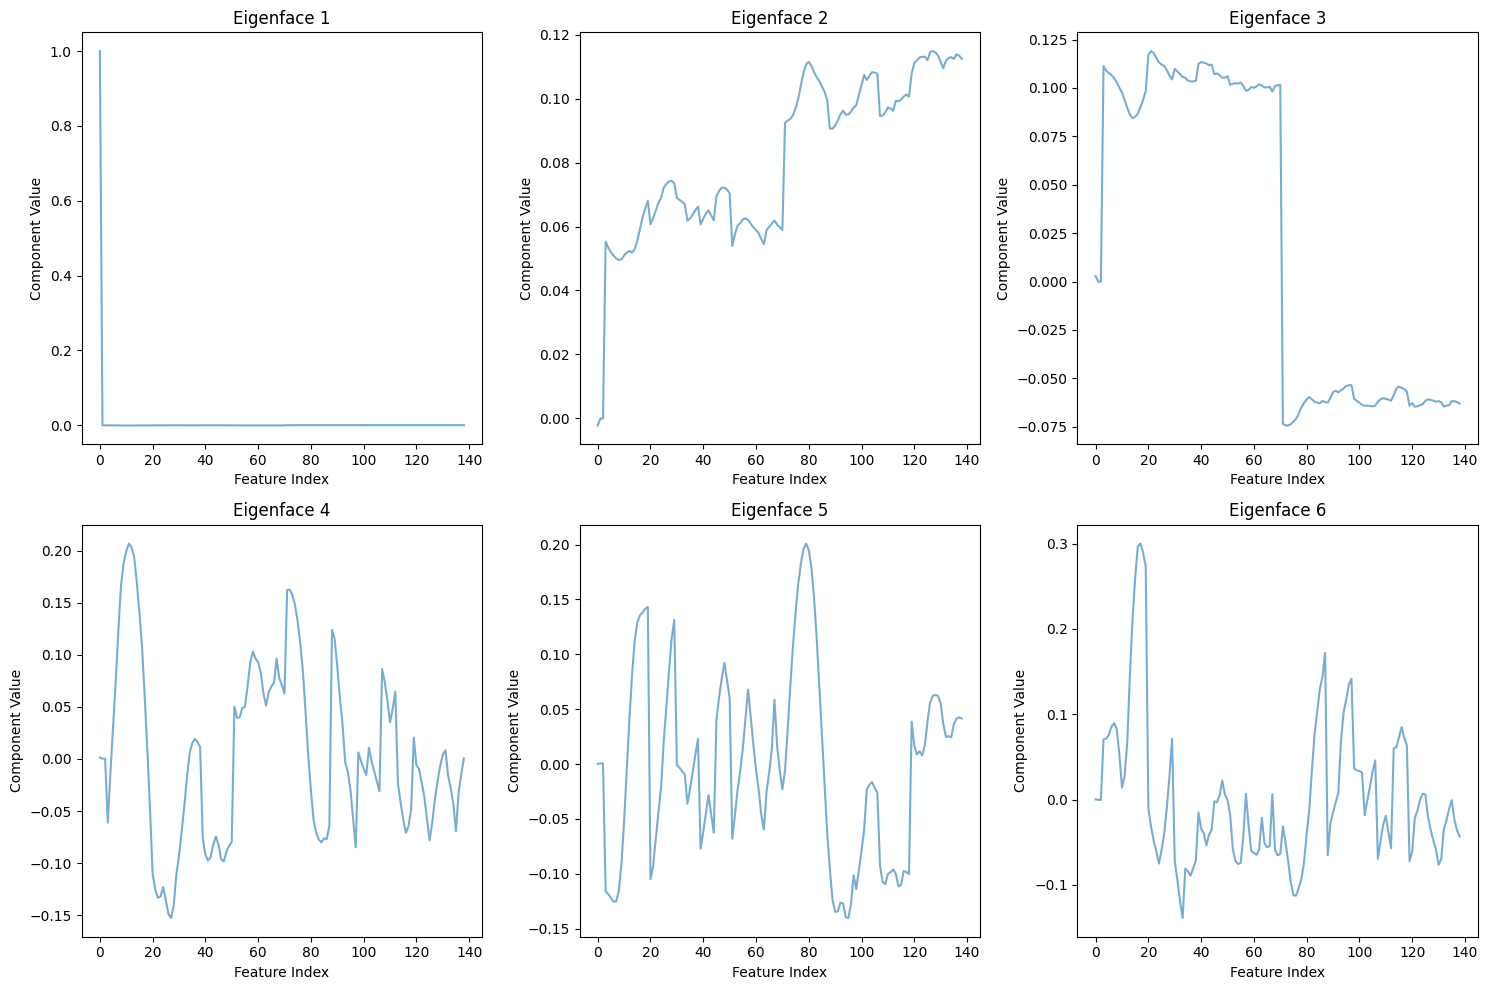

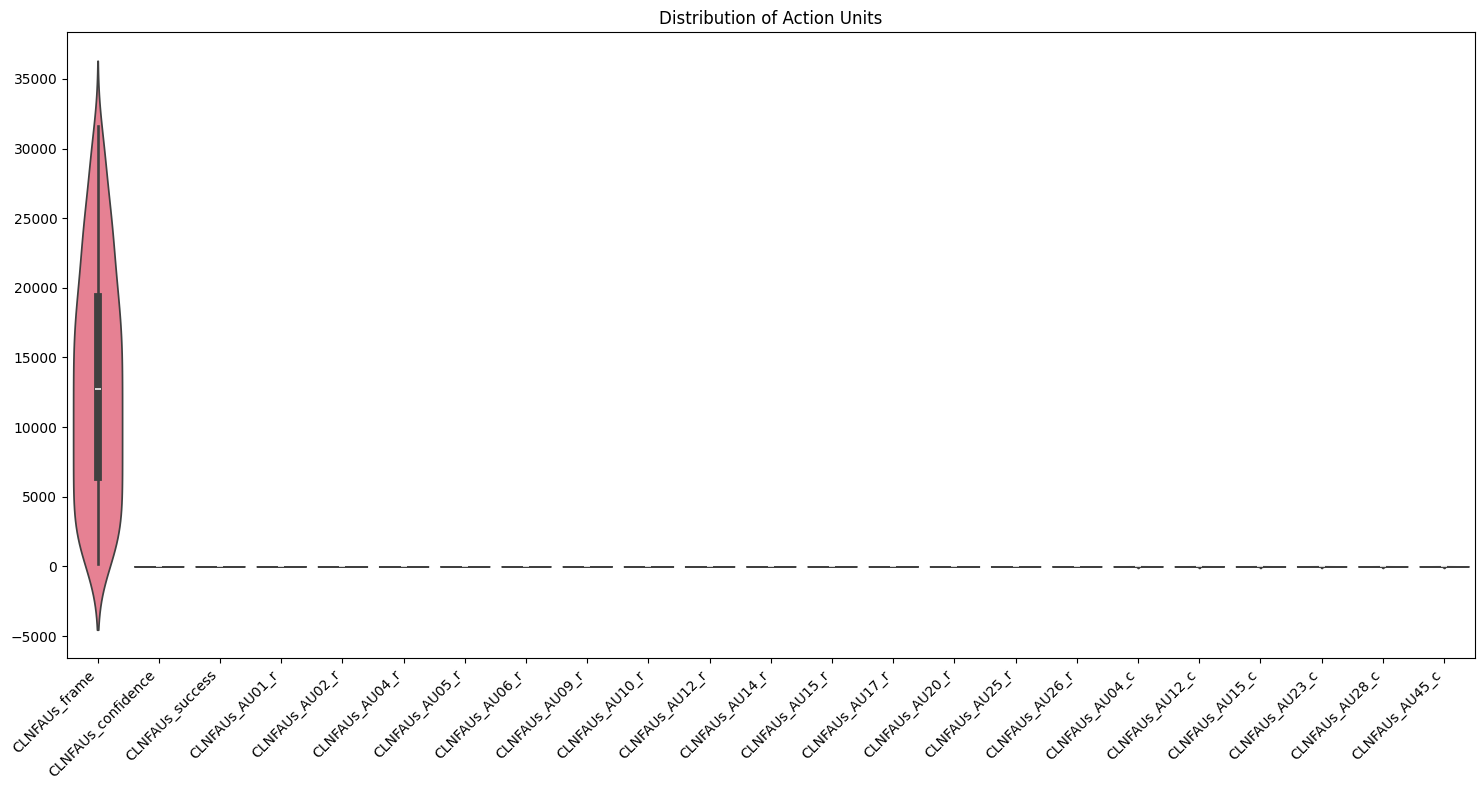

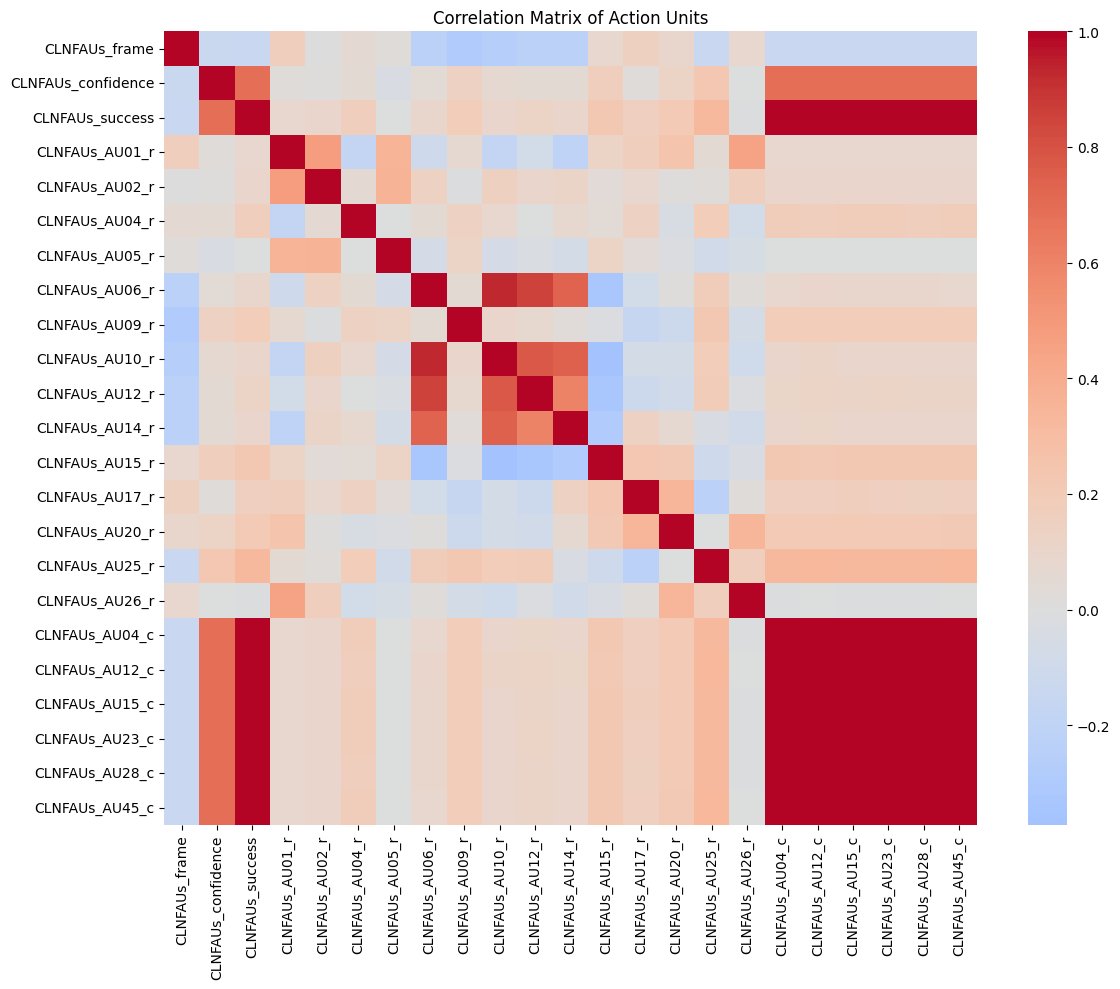

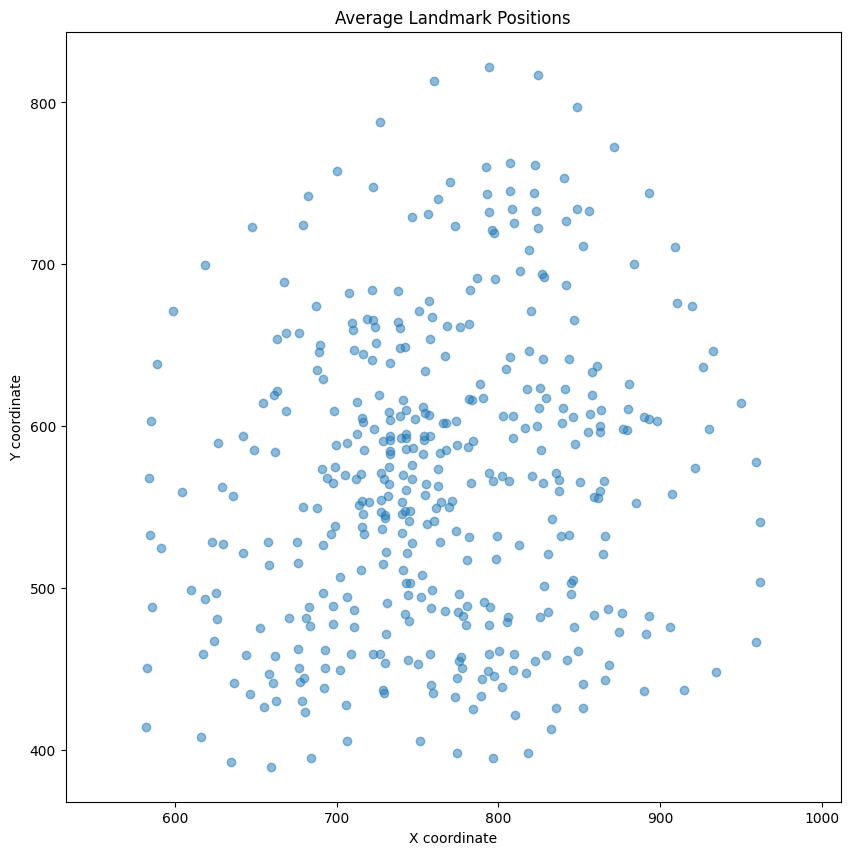

In [5]:
def analyze_landmarks(df: pd.DataFrame) -> None:
    #Analyze facial landmarks using PCA and visualization.
    # Extract landmark features
    landmark_features = [col for col in df.columns if 'CLNFfeatures_' in col]
    landmark_data = df[landmark_features]

    # Perform PCA
    pca = PCA(n_components=10)
    landmark_pca = pca.fit_transform(landmark_data)

    # Plot explained variance ratio
    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Explained Variance Ratio of Landmark PCA Components')
    plt.show()

    # Plot eigenfaces -> robust to feature count
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(6):
        if i < len(pca.components_):
            comp = pca.components_[i]
            n_points = comp.shape[0] // 2
            if n_points > 0 and n_points * 2 == comp.shape[0]:
                x = comp[:n_points]
                y = comp[n_points:]
                axes[i].scatter(x, y, alpha=0.6)
                axes[i].set_xlabel('X coordinate')
                axes[i].set_ylabel('Y coordinate')
            else:
                axes[i].plot(comp, alpha=0.6)
                axes[i].set_xlabel('Feature Index')
                axes[i].set_ylabel('Component Value')
            axes[i].set_title(f'Eigenface {i + 1}')

    plt.tight_layout()
    plt.show()


def analyze_action_units(df: pd.DataFrame) -> None:
    #Analyze facial action units using visualization.
    # Extract action unit features
    au_features = [col for col in df.columns if 'CLNFAUs_' in col]

    # Create violin plots
    plt.figure(figsize=FIGURE_SIZE)
    sns.violinplot(data=df[au_features])
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Action Units')
    plt.tight_layout()
    plt.show()

    # Correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[au_features].corr(), cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Action Units')
    plt.tight_layout()
    plt.show()


def plot_landmark_positions(df: pd.DataFrame) -> None:
    #Plot average landmark positions for each subject.
    landmark_features = [col for col in df.columns if 'CLNFfeatures_' in col]
    mean_landmarks = df.groupby('ID')[landmark_features].mean()

    x_coords = mean_landmarks[[col for col in landmark_features if '_x' in col]].values
    y_coords = mean_landmarks[[col for col in landmark_features if '_y' in col]].values

    plt.figure(figsize=(10, 10))
    plt.scatter(x_coords, y_coords, alpha=0.5)
    plt.title('Average Landmark Positions')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.axis('equal')
    plt.show()


# Perform EDA
analyze_landmarks(df_face)
analyze_action_units(df_face)
plot_landmark_positions(df_face)

## Principal Component Analysis

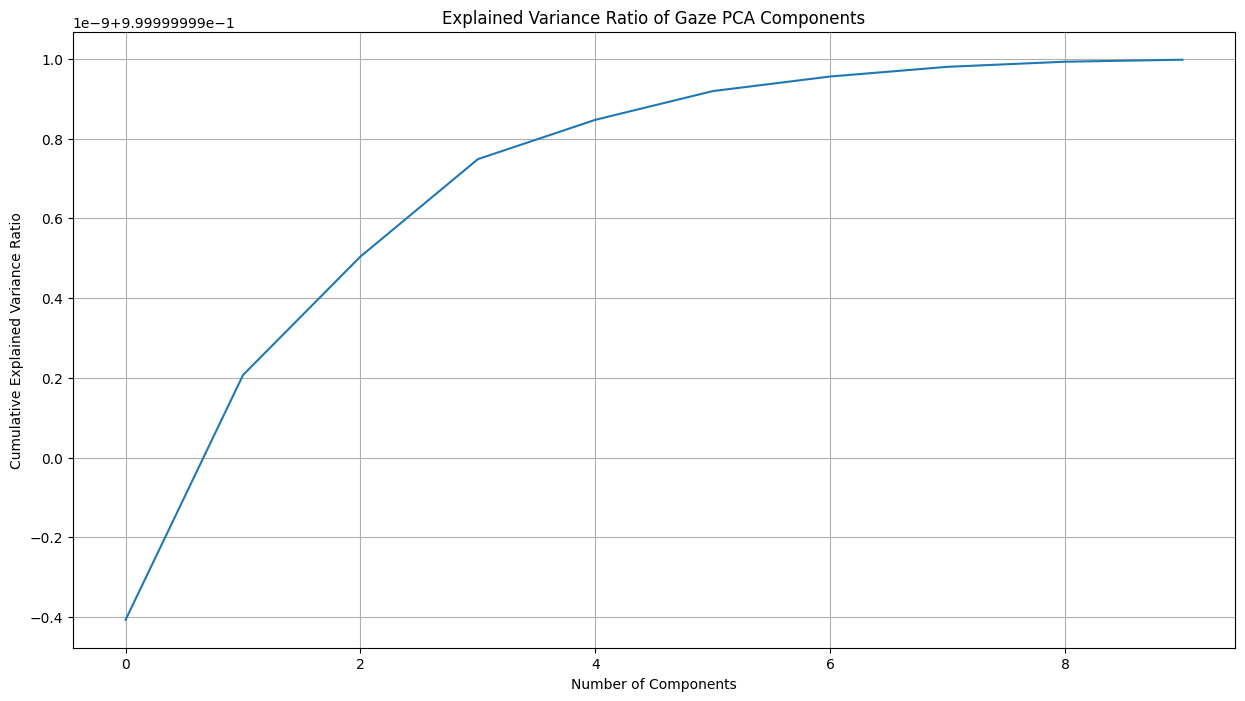


Gaze - Explained variance ratio by component:
PC1: 1.0000
PC2: 0.0000
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000
PC10: 0.0000


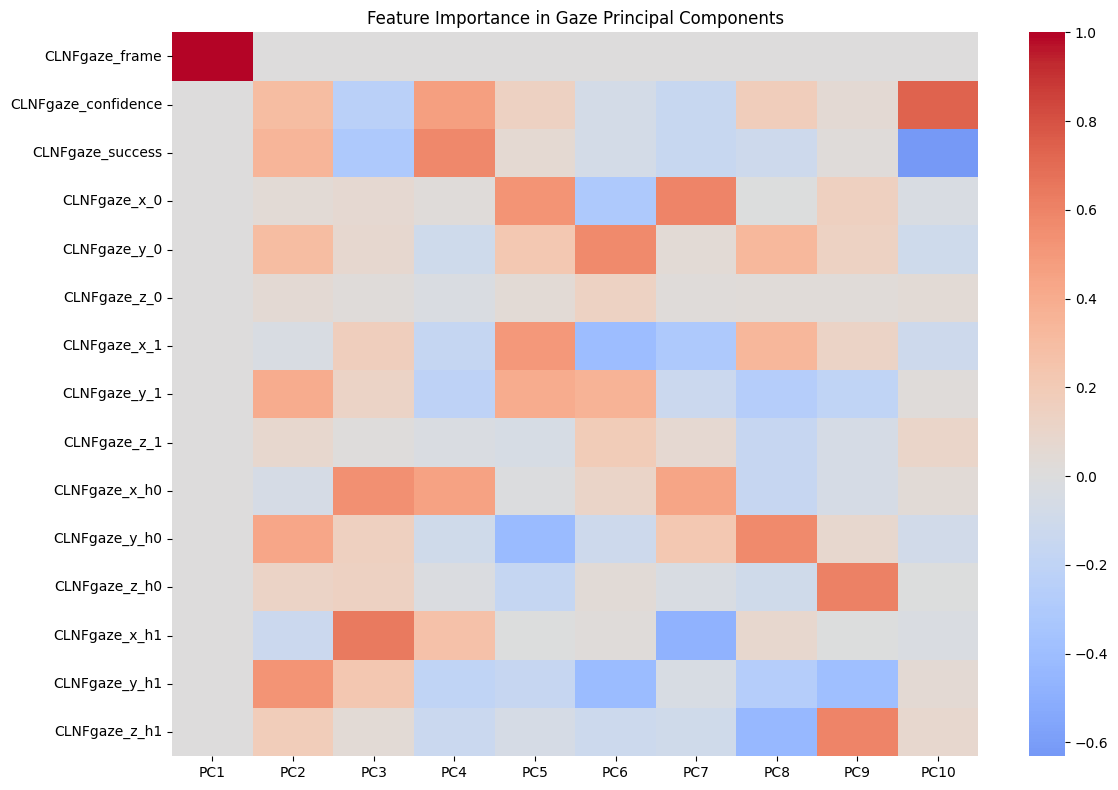

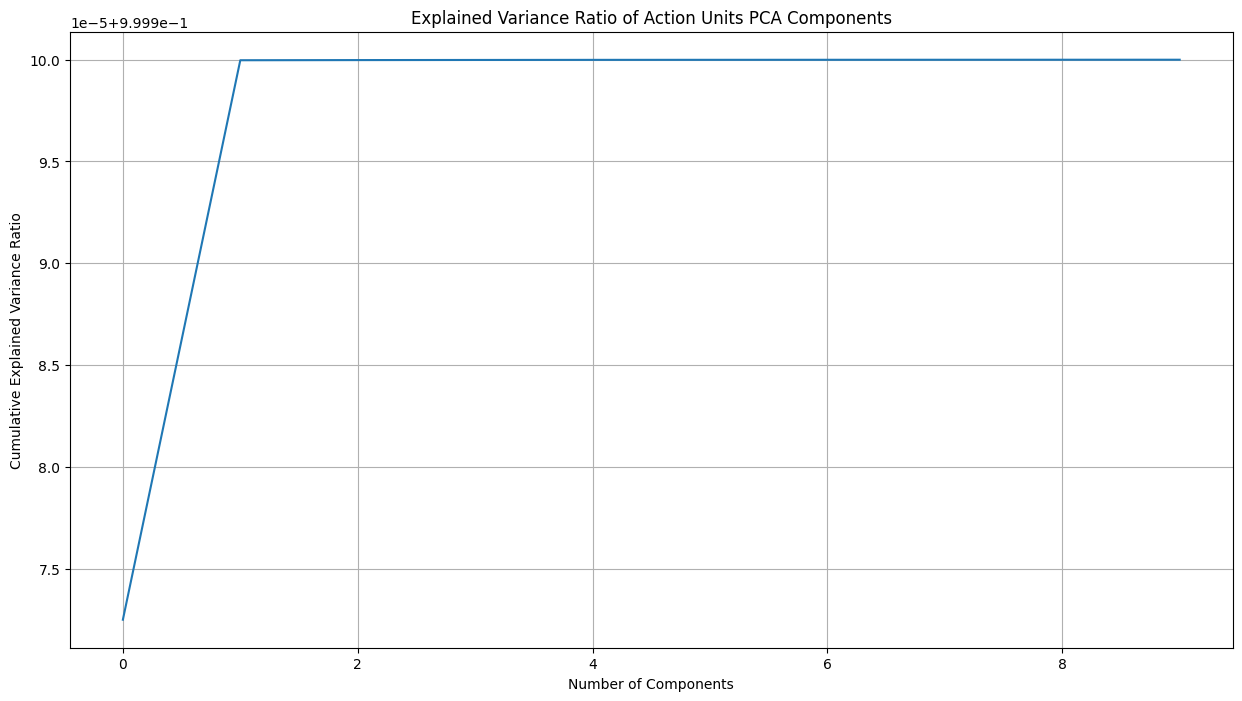


Action Units - Explained variance ratio by component:
PC1: 1.0000
PC2: 0.0000
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000
PC10: 0.0000


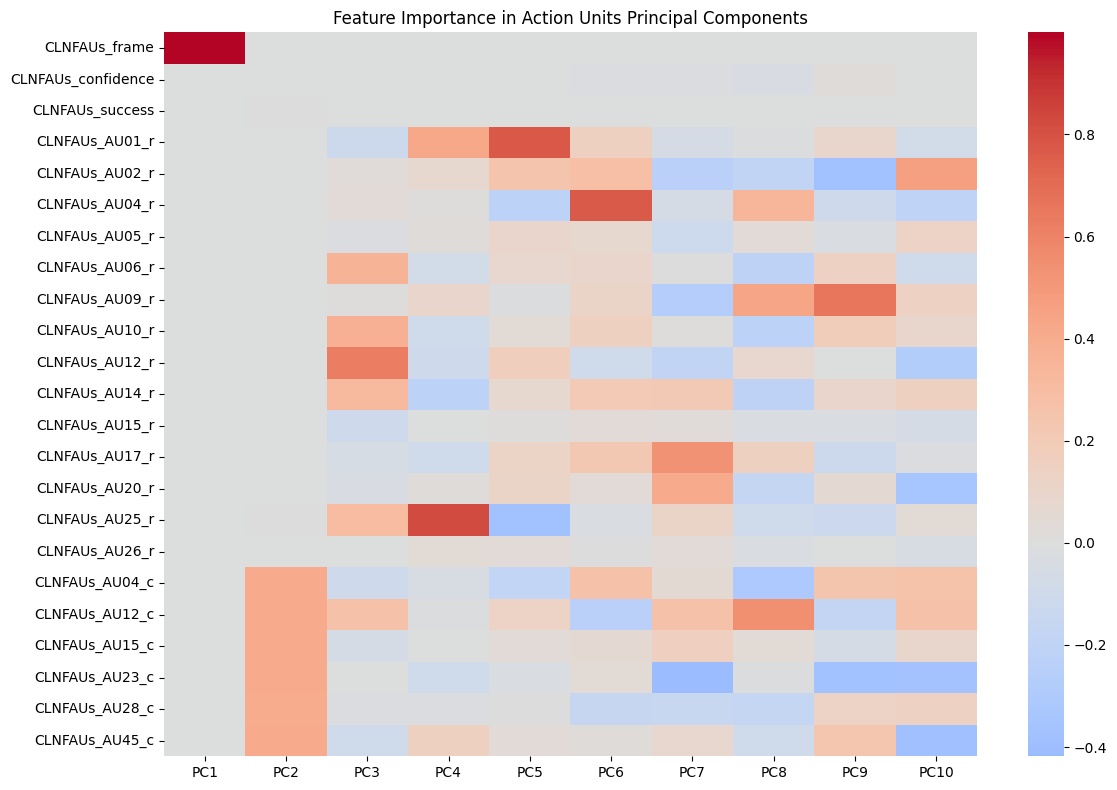

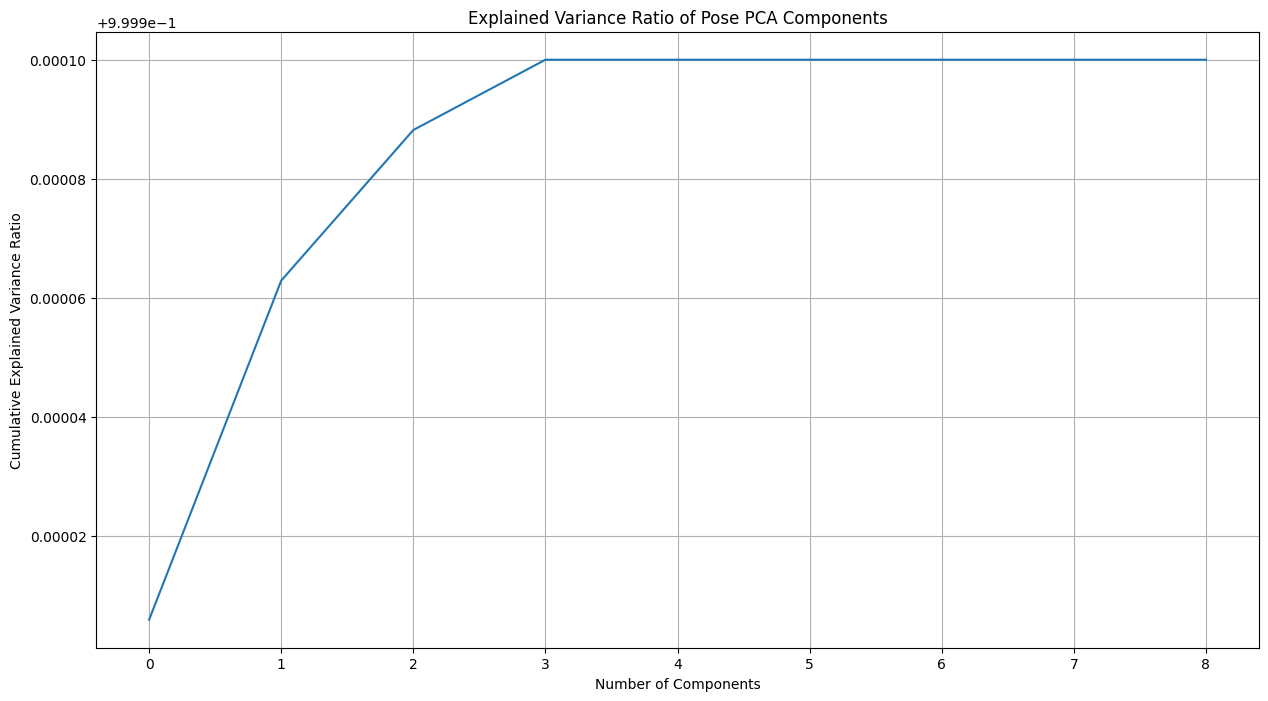


Pose - Explained variance ratio by component:
PC1: 0.9999
PC2: 0.0001
PC3: 0.0000
PC4: 0.0000
PC5: 0.0000
PC6: 0.0000
PC7: 0.0000
PC8: 0.0000
PC9: 0.0000


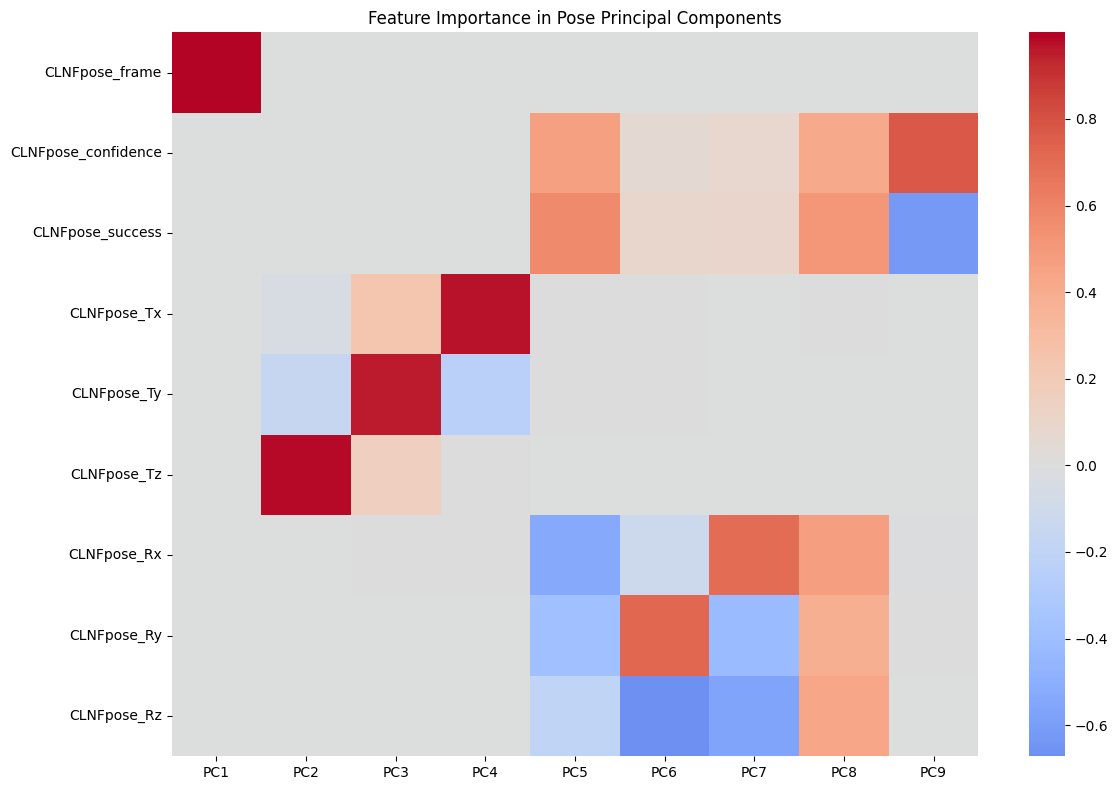

In [6]:
from utils.pca_utils import save_pca_components


def perform_feature_pca(df: pd.DataFrame, n_components: int = 10):
    #Perform PCA on different facial feature types.
    # Extract different feature types
    feature_types = {
        'Gaze': [col for col in df.columns if 'CLNFgaze_' in col],
        'Action Units': [col for col in df.columns if 'CLNFAUs_' in col],
        'Pose': [col for col in df.columns if 'CLNFpose_' in col]
    }

    # Dictionary to store PCA results
    pca_results = {}

    # Perform PCA for each feature type
    for feature_name, features in feature_types.items():
        if not features:
            continue

        # Extract data and perform PCA
        feature_data = df[features]
        pca = PCA(n_components=min(n_components, len(features)))
        feature_pca = pca.fit_transform(feature_data)

        # Determine the most important features for the first principal component
        abs_loadings = np.abs(pca.components_[0])
        sorted_indices = np.argsort(abs_loadings)[::-1]
        feature_names = [features[i] for i in sorted_indices[:min(n_components, len(features))]]

        # For compatibility, return the last computed PCA's importance
        feature_importance = pd.DataFrame(
            pca.components_.T,
            columns=[f'PC{i + 1}' for i in range(feature_pca.shape[1])],
            index=feature_data.columns
        )

        # Store results
        pca_results[feature_name] = {
            'pca': pca,
            'feature_pca': feature_pca,
            'feature_names': feature_names,
            'feature_importance': feature_importance
        }

        # Save PCA components
        save_pca_components(
            pca=pca,
            feature_names=feature_names,
            output_path=f'models/pca_face_{feature_name.lower().replace(" ", "_")}.pkl'
        )

    # Create combined PCA features DataFrame
    pca_df = pd.DataFrame(index=df.index)
    for feature_name, result in pca_results.items():
        pca_df[result['feature_names']] = result['feature_pca']

    return pca_df, pca_results


# Perform PCA
pca_df, pca_results = perform_feature_pca(df_face)

# Plot graphs
for feature_name, result in pca_results.items():
    pca = result['pca']
    # feature_pca = result['feature_pca'] # is this ok?
    feature_importance = result['feature_importance']

    # Plot explained variance ratio
    plt.figure(figsize=FIGURE_SIZE)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title(f'Explained Variance Ratio of {feature_name} PCA Components')
    plt.grid(True)
    plt.show()

    # Print variance explained
    print(f"\n{feature_name} - Explained variance ratio by component:")
    for i, ratio in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i + 1}: {ratio:.4f}")

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.heatmap(feature_importance, cmap='coolwarm', center=0)
    plt.title(f'Feature Importance in {feature_name} Principal Components')
    plt.tight_layout()
    plt.show()



## Data Splitting

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

# def prepare_data_splits(df_face: pd.DataFrame, df_result: pd.DataFrame) -> Tuple[
#     np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
#     #Prepare data splits for training, validation, and testing.
#     # Merge facial features with depression labels
#     df = pd.merge(df_face, df_result, on='ID')

#     # Prepare features and target
#     X = df.drop(['PHQ_Binary'], axis=1)
#     y = df['PHQ_Binary']

#     # Create time series split
#     tscv = TimeSeriesSplit(n_splits=5)
#     train_indices = []
#     test_indices = []

#     # Get split indices while preserving temporal order
#     for train_idx, test_idx in tscv.split(X):
#         train_indices.append(train_idx)
#         test_indices.append(test_idx)

#     # Use the last fold for final train/test split
#     X_train = X.iloc[train_indices[-1]]
#     X_test = X.iloc[test_indices[-1]]
#     y_train = y.iloc[train_indices[-1]]
#     y_test = y.iloc[test_indices[-1]]

#     # Further split training data into train and validation
#     train_size = int(0.75 * len(X_train))
#     X_train, X_val = X_train.iloc[:train_size], X_train.iloc[train_size:]
#     y_train, y_val = y_train.iloc[:train_size], y_train.iloc[train_size:]

#     # Standardize features
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
#     X_test = scaler.transform(X_test)

#     return X_train, X_val, X_test, y_train, y_val, y_test, scaler

# def prepare_data_splits(df_face: pd.DataFrame, df_result: pd.DataFrame) -> Tuple[
#     np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
#     # Reset index of df_result to make 'ID' a column
#     df_result = df_result.reset_index()


# Prepare data splits
# X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data_splits(pca_df, df_result)


def print_split_results(groups, groups_temp, test_idx, train_idx, val_idx, y_test, y_train, y_val):
    print("Split overview:")
    print("-" * 50)
    # Get unique IDs for each split
    train_ids = groups.iloc[train_idx].unique()
    val_ids = groups_temp.iloc[val_idx].unique()
    test_ids = groups_temp.iloc[test_idx].unique()
    print("Sessions in training set:", len(train_ids))
    print(train_ids)
    print("\nSessions in validation set:", len(val_ids))
    print(val_ids)
    print("\nSessions in test set:", len(test_ids))
    print(test_ids)
    print("-" * 50)
    print("Training set:")
    train_dep_ids = groups.iloc[train_idx][y_train == 1].unique()
    train_nondep_ids = groups.iloc[train_idx][y_train == 0].unique()
    total_train_ids = len(train_dep_ids) + len(train_nondep_ids)
    train_dep_pct = (len(train_dep_ids) / total_train_ids) * 100
    print(f"Depressed ({train_dep_pct:.1f}%):")
    print(train_dep_ids)
    print(f"Non-depressed ({100 - train_dep_pct:.1f}%):")
    print(train_nondep_ids)
    print("\nValidation set:")
    val_dep_ids = groups_temp.iloc[val_idx][y_val == 1].unique()
    val_nondep_ids = groups_temp.iloc[val_idx][y_val == 0].unique()
    total_val_ids = len(val_dep_ids) + len(val_nondep_ids)
    val_dep_pct = (len(val_dep_ids) / total_val_ids) * 100
    print(f"Depressed ({val_dep_pct:.1f}%):")
    print(val_dep_ids)
    print(f"Non-depressed ({100 - val_dep_pct:.1f}%):")
    print(val_nondep_ids)
    print("\nTest set:")
    test_dep_ids = groups_temp.iloc[test_idx][y_test == 1].unique()
    test_nondep_ids = groups_temp.iloc[test_idx][y_test == 0].unique()
    total_test_ids = len(test_dep_ids) + len(test_nondep_ids)
    test_dep_pct = (len(test_dep_ids) / total_test_ids) * 100
    print(f"Depressed ({test_dep_pct:.1f}%):")
    print(test_dep_ids)
    print(f"Non-depressed ({100 - test_dep_pct:.1f}%):")
    print(test_nondep_ids)
    print("-" * 50)


def check_temporal_consistency(X_train, X_val, X_test, df):
    for session_id in df['ID'].unique():
        session_times = df[df['ID'] == session_id]['TIMESTAMP']
        if len(session_times) > 1:
            time_diff = session_times.diff().dropna()
            if (time_diff < pd.Timedelta(0)).any():
                print(f"Warning: Temporal inconsistency detected in session {session_id}")

#TODO: go over this function again to see if you need to make any changes for the face modality
#NOTE: need to double check if there are any special considerations i have to take into account regarding the modality of the data that we are splitting
def prepare_data_splits(df_face: pd.DataFrame, df_result: pd.DataFrame) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, StandardScaler]:
    
    # Reset index of df_result to make 'ID' a column
    df_result = df_result.reset_index()
    df_face = df_face.reset_index()

    # Merge face features with depression labels
    df = pd.merge(df_face, df_result, on='ID')
    
    # Prepare features and target 
    X = df.drop(['PHQ_Binary', 'ID', 'TIMESTAMP'], axis=1)  # Drop ID and TIMESTAMP as they're not features 
    y = df['PHQ_Binary']
    groups = df['ID']  # Use ID as the grouping variable
    
    # First split: 60% train, 40% temp (which will be split into val and test)
    gss_train = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=42)
    train_idx, temp_idx = next(gss_train.split(X, y, groups))
    
    # Get the temporary set
    X_temp = X.iloc[temp_idx]
    y_temp = y.iloc[temp_idx]
    groups_temp = groups.iloc[temp_idx]
    
    # Second split: Split the remaining 40% into validation and test (50-50 split, which gives us 20-20 of original)
    gss_val = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=42)
    val_idx, test_idx = next(gss_val.split(X_temp, y_temp, groups_temp))
    
    # Get the final splits
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = X_temp.iloc[val_idx]
    y_val = y_temp.iloc[val_idx]
    X_test = X_temp.iloc[test_idx]
    y_test = y_temp.iloc[test_idx]
    
    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Check for temporal consistency
    check_temporal_consistency(X_train, X_val, X_test, df)

    # Print split results
    print_split_results(groups, groups_temp, test_idx, train_idx, val_idx, y_test, y_train, y_val)

    return X_train, X_val, X_test, y_train, y_val, y_test, scaler


# Prepare data splits
X_train, X_val, X_test, y_train, y_val, y_test, scaler = prepare_data_splits(pca_df, df_result)




Data Split Information:
Training set: 2 sessions (175 samples)
Validation set: 2 sessions (193 samples)
Test set: 2 sessions (145 samples)

Class Distribution in Sessions:
Training - Positive: 50.00%, Negative: 50.00%
Validation - Positive: 50.00%, Negative: 50.00%
Test - Positive: 50.00%, Negative: 50.00%


## Model Training

  0%|          | 0/72 [00:00<?, ?it/s]/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Validation: 100%|██████████| 7/7 [00:01<00:00,  5.81it/s, loss=0.6279]


Epoch 1/50
Train Loss: 0.6254, Val Loss: 0.6916, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 210.44it/s, loss=0.6706]


Epoch 2/50
Train Loss: 0.1876, Val Loss: 0.6942, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 208.79it/s, loss=0.7292]


Epoch 3/50
Train Loss: 0.0826, Val Loss: 0.6975, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 93.69it/s, loss=0.8089]


Epoch 4/50
Train Loss: 0.0644, Val Loss: 0.7047, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 214.60it/s, loss=0.9321]


Epoch 5/50
Train Loss: 0.0391, Val Loss: 0.7213, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.05it/s, loss=0.9846]


Epoch 6/50
Train Loss: 0.0249, Val Loss: 0.7310, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.73it/s, loss=1.0814]


Epoch 7/50
Train Loss: 0.0283, Val Loss: 0.7486, LR: 0.000100


  1%|▏         | 1/72 [00:06<07:28,  6.32s/it]

Epoch 8/50
Train Loss: 0.0260, Val Loss: 0.7769, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 215.32it/s, loss=0.6851]


Epoch 1/50
Train Loss: 0.4110, Val Loss: 0.6937, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 216.51it/s, loss=0.7330]


Epoch 2/50
Train Loss: 0.1686, Val Loss: 0.6990, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.14it/s, loss=0.7925]


Epoch 3/50
Train Loss: 0.0664, Val Loss: 0.7090, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.82it/s, loss=0.8669]


Epoch 4/50
Train Loss: 0.0450, Val Loss: 0.7237, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 103.54it/s, loss=0.9506]


Epoch 5/50
Train Loss: 0.0317, Val Loss: 0.7426, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 232.17it/s, loss=1.0446]


Epoch 6/50
Train Loss: 0.0299, Val Loss: 0.7651, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.03it/s, loss=1.1511]


Epoch 7/50
Train Loss: 0.0276, Val Loss: 0.7958, LR: 0.000100


  3%|▎         | 2/72 [00:07<04:04,  3.50s/it]

Epoch 8/50
Train Loss: 0.0199, Val Loss: 0.8376, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 159.03it/s, loss=0.7245]


Epoch 1/50
Train Loss: 0.3465, Val Loss: 0.6935, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 207.11it/s, loss=0.7471]


Epoch 2/50
Train Loss: 0.1274, Val Loss: 0.6937, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 185.05it/s, loss=0.7977]


Epoch 3/50
Train Loss: 0.0675, Val Loss: 0.6983, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 201.73it/s, loss=0.8464]


Epoch 4/50
Train Loss: 0.0340, Val Loss: 0.7036, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 209.50it/s, loss=0.8888]


Epoch 5/50
Train Loss: 0.0247, Val Loss: 0.7085, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 189.11it/s, loss=0.8940]


Epoch 6/50
Train Loss: 0.0241, Val Loss: 0.7114, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 209.21it/s, loss=0.9172]


Epoch 7/50
Train Loss: 0.0216, Val Loss: 0.7202, LR: 0.000100


  4%|▍         | 3/72 [00:09<03:13,  2.81s/it]

Epoch 8/50
Train Loss: 0.0185, Val Loss: 0.7394, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 192.99it/s, loss=0.7202]


Epoch 1/50
Train Loss: 0.4337, Val Loss: 0.6939, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 204.37it/s, loss=0.7527]


Epoch 2/50
Train Loss: 0.0974, Val Loss: 0.6955, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.39it/s, loss=0.8005]


Epoch 3/50
Train Loss: 0.0616, Val Loss: 0.7005, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 220.18it/s, loss=0.8691]


Epoch 4/50
Train Loss: 0.0438, Val Loss: 0.7156, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 214.87it/s, loss=0.9262]


Epoch 5/50
Train Loss: 0.0317, Val Loss: 0.7289, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.18it/s, loss=0.9193]


Epoch 6/50
Train Loss: 0.0189, Val Loss: 0.7393, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 228.59it/s, loss=0.8861]


Epoch 7/50
Train Loss: 0.0282, Val Loss: 0.7558, LR: 0.000100


  6%|▌         | 4/72 [00:11<02:43,  2.41s/it]

Epoch 8/50
Train Loss: 0.0262, Val Loss: 0.7843, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.76it/s, loss=0.7081]


Epoch 1/50
Train Loss: 0.7571, Val Loss: 0.6966, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.67it/s, loss=0.7122]


Epoch 2/50
Train Loss: 0.6620, Val Loss: 0.6979, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.48it/s, loss=0.7161]


Epoch 3/50
Train Loss: 0.5626, Val Loss: 0.6995, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 240.65it/s, loss=0.7194]


Epoch 4/50
Train Loss: 0.5137, Val Loss: 0.7015, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 257.96it/s, loss=0.7251]


Epoch 5/50
Train Loss: 0.4385, Val Loss: 0.7043, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 211.72it/s, loss=0.7252]


Epoch 6/50
Train Loss: 0.4134, Val Loss: 0.7075, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.70it/s, loss=0.7215]


Epoch 7/50
Train Loss: 0.3879, Val Loss: 0.7116, LR: 0.000010


  7%|▋         | 5/72 [00:13<02:18,  2.06s/it]

Epoch 8/50
Train Loss: 0.4036, Val Loss: 0.7174, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.25it/s, loss=0.6971]


Epoch 1/50
Train Loss: 0.7060, Val Loss: 0.6914, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.45it/s, loss=0.7003]


Epoch 2/50
Train Loss: 0.5926, Val Loss: 0.6911, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.88it/s, loss=0.7058]


Epoch 3/50
Train Loss: 0.5183, Val Loss: 0.6908, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 257.38it/s, loss=0.7172]


Epoch 4/50
Train Loss: 0.4637, Val Loss: 0.6910, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.62it/s, loss=0.7311]


Epoch 5/50
Train Loss: 0.4326, Val Loss: 0.6914, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.67it/s, loss=0.7536]


Epoch 6/50
Train Loss: 0.3669, Val Loss: 0.6924, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.14it/s, loss=0.7865]


Epoch 7/50
Train Loss: 0.3375, Val Loss: 0.6945, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.73it/s, loss=0.8279]


Epoch 8/50
Train Loss: 0.3203, Val Loss: 0.6967, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.76it/s, loss=0.8749]


Epoch 9/50
Train Loss: 0.2998, Val Loss: 0.6999, LR: 0.000010


  8%|▊         | 6/72 [00:14<02:09,  1.97s/it]

Epoch 10/50
Train Loss: 0.3142, Val Loss: 0.7047, LR: 0.000010
Early stopping triggered at epoch 10


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.04it/s, loss=0.7608]


Epoch 1/50
Train Loss: 0.6915, Val Loss: 0.6998, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 203.40it/s, loss=0.7624]


Epoch 2/50
Train Loss: 0.5138, Val Loss: 0.7000, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 218.19it/s, loss=0.7649]


Epoch 3/50
Train Loss: 0.3933, Val Loss: 0.7005, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.88it/s, loss=0.7675]


Epoch 4/50
Train Loss: 0.3405, Val Loss: 0.7010, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.35it/s, loss=0.7752]


Epoch 5/50
Train Loss: 0.2561, Val Loss: 0.7022, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 193.50it/s, loss=0.7790]


Epoch 6/50
Train Loss: 0.2289, Val Loss: 0.7033, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 220.46it/s, loss=0.7831]


Epoch 7/50
Train Loss: 0.2564, Val Loss: 0.7047, LR: 0.000010


 10%|▉         | 7/72 [00:16<02:03,  1.90s/it]

Epoch 8/50
Train Loss: 0.2187, Val Loss: 0.7076, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 211.21it/s, loss=0.7144]


Epoch 1/50
Train Loss: 0.6318, Val Loss: 0.6961, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 220.18it/s, loss=0.7170]


Epoch 2/50
Train Loss: 0.5436, Val Loss: 0.6966, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 226.41it/s, loss=0.7197]


Epoch 3/50
Train Loss: 0.4671, Val Loss: 0.6974, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 97.42it/s, loss=0.7229]


Epoch 4/50
Train Loss: 0.3854, Val Loss: 0.6980, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 217.56it/s, loss=0.7251]


Epoch 5/50
Train Loss: 0.3395, Val Loss: 0.6991, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 209.93it/s, loss=0.7255]


Epoch 6/50
Train Loss: 0.3017, Val Loss: 0.7006, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 103.79it/s, loss=0.7205]


Epoch 7/50
Train Loss: 0.3137, Val Loss: 0.7024, LR: 0.000010


 11%|█         | 8/72 [00:18<01:59,  1.86s/it]

Epoch 8/50
Train Loss: 0.2951, Val Loss: 0.7058, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 123.69it/s, loss=0.7272]


Epoch 1/50
Train Loss: 0.3338, Val Loss: 0.6997, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 116.76it/s, loss=0.7946]


Epoch 2/50
Train Loss: 0.0664, Val Loss: 0.7101, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 227.30it/s, loss=0.8844]


Epoch 3/50
Train Loss: 0.0412, Val Loss: 0.7242, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.25it/s, loss=0.9888]


Epoch 4/50
Train Loss: 0.0111, Val Loss: 0.7411, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 131.21it/s, loss=1.1340]


Epoch 5/50
Train Loss: 0.0088, Val Loss: 0.7693, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.23it/s, loss=1.2925]


Epoch 6/50
Train Loss: 0.0060, Val Loss: 0.8053, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 230.93it/s, loss=1.5051]


Epoch 7/50
Train Loss: 0.0093, Val Loss: 0.8571, LR: 0.000100


 12%|█▎        | 9/72 [00:20<01:55,  1.84s/it]

Epoch 8/50
Train Loss: 0.0090, Val Loss: 0.9135, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 238.66it/s, loss=0.7450]


Epoch 1/50
Train Loss: 0.4213, Val Loss: 0.6987, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 238.63it/s, loss=0.7983]


Epoch 2/50
Train Loss: 0.0487, Val Loss: 0.7094, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 249.76it/s, loss=0.8786]


Epoch 3/50
Train Loss: 0.0255, Val Loss: 0.7255, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.90it/s, loss=0.9952]


Epoch 4/50
Train Loss: 0.0107, Val Loss: 0.7510, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.12it/s, loss=1.1726]


Epoch 5/50
Train Loss: 0.0087, Val Loss: 0.7917, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 189.35it/s, loss=1.3119]


Epoch 6/50
Train Loss: 0.0060, Val Loss: 0.8313, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.38it/s, loss=1.4978]


Epoch 7/50
Train Loss: 0.0049, Val Loss: 0.8874, LR: 0.000100


 14%|█▍        | 10/72 [00:21<01:47,  1.74s/it]

Epoch 8/50
Train Loss: 0.0047, Val Loss: 0.9731, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 141.70it/s, loss=0.7570]


Epoch 1/50
Train Loss: 0.2802, Val Loss: 0.6987, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 242.67it/s, loss=0.7948]


Epoch 2/50
Train Loss: 0.0522, Val Loss: 0.7030, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.03it/s, loss=0.8338]


Epoch 3/50
Train Loss: 0.0171, Val Loss: 0.7137, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 214.28it/s, loss=0.8678]


Epoch 4/50
Train Loss: 0.0151, Val Loss: 0.7308, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 214.08it/s, loss=0.9620]


Epoch 5/50
Train Loss: 0.0064, Val Loss: 0.7770, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.06it/s, loss=0.9324]


Epoch 6/50
Train Loss: 0.0078, Val Loss: 0.8031, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.32it/s, loss=0.9165]


Epoch 7/50
Train Loss: 0.0060, Val Loss: 0.8464, LR: 0.000100


 15%|█▌        | 11/72 [00:23<01:50,  1.82s/it]

Epoch 8/50
Train Loss: 0.0074, Val Loss: 0.9041, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 216.24it/s, loss=0.6970]


Epoch 1/50
Train Loss: 0.2518, Val Loss: 0.6978, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.88it/s, loss=0.7336]


Epoch 2/50
Train Loss: 0.0403, Val Loss: 0.7082, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 218.36it/s, loss=0.7806]


Epoch 3/50
Train Loss: 0.0246, Val Loss: 0.7262, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 211.93it/s, loss=0.8384]


Epoch 4/50
Train Loss: 0.0159, Val Loss: 0.7512, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 228.18it/s, loss=0.8925]


Epoch 5/50
Train Loss: 0.0051, Val Loss: 0.7913, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 222.39it/s, loss=0.9372]


Epoch 6/50
Train Loss: 0.0043, Val Loss: 0.8371, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.00it/s, loss=0.9025]


Epoch 7/50
Train Loss: 0.0083, Val Loss: 0.8830, LR: 0.000100


 17%|█▋        | 12/72 [00:25<01:48,  1.81s/it]

Epoch 8/50
Train Loss: 0.0052, Val Loss: 0.9528, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 104.04it/s, loss=0.6728]


Epoch 1/50
Train Loss: 0.4975, Val Loss: 0.6902, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 230.88it/s, loss=0.6780]


Epoch 2/50
Train Loss: 0.3370, Val Loss: 0.6900, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.11it/s, loss=0.6890]


Epoch 3/50
Train Loss: 0.2532, Val Loss: 0.6903, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 101.12it/s, loss=0.7026]


Epoch 4/50
Train Loss: 0.2093, Val Loss: 0.6908, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 230.19it/s, loss=0.7256]


Epoch 5/50
Train Loss: 0.1396, Val Loss: 0.6925, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.17it/s, loss=0.7616]


Epoch 6/50
Train Loss: 0.1150, Val Loss: 0.6959, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 103.22it/s, loss=0.7969]


Epoch 7/50
Train Loss: 0.1166, Val Loss: 0.6985, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 232.57it/s, loss=0.8453]


Epoch 8/50
Train Loss: 0.0934, Val Loss: 0.7029, LR: 0.000010


 18%|█▊        | 13/72 [00:27<01:44,  1.77s/it]

Epoch 9/50
Train Loss: 0.0926, Val Loss: 0.7119, LR: 0.000010
Early stopping triggered at epoch 9


Validation: 100%|██████████| 7/7 [00:00<00:00, 106.38it/s, loss=0.7751]


Epoch 1/50
Train Loss: 0.7649, Val Loss: 0.6996, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.01it/s, loss=0.7796]


Epoch 2/50
Train Loss: 0.5376, Val Loss: 0.6989, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.76it/s, loss=0.7868]


Epoch 3/50
Train Loss: 0.3782, Val Loss: 0.6979, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 118.19it/s, loss=0.7969]


Epoch 4/50
Train Loss: 0.2795, Val Loss: 0.6965, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 242.19it/s, loss=0.8093]


Epoch 5/50
Train Loss: 0.2047, Val Loss: 0.6943, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.83it/s, loss=0.8314]


Epoch 6/50
Train Loss: 0.1355, Val Loss: 0.6924, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 242.77it/s, loss=0.8624]


Epoch 7/50
Train Loss: 0.1247, Val Loss: 0.6905, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.75it/s, loss=0.9025]


Epoch 8/50
Train Loss: 0.0866, Val Loss: 0.6891, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.50it/s, loss=0.9656]


Epoch 9/50
Train Loss: 0.0758, Val Loss: 0.6913, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 231.29it/s, loss=1.0273]


Epoch 10/50
Train Loss: 0.0635, Val Loss: 0.6960, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.31it/s, loss=1.1216]


Epoch 11/50
Train Loss: 0.0536, Val Loss: 0.7099, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 255.23it/s, loss=1.2172]


Epoch 12/50
Train Loss: 0.0438, Val Loss: 0.7275, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 129.50it/s, loss=1.2834]


Epoch 13/50
Train Loss: 0.0395, Val Loss: 0.7388, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.99it/s, loss=1.3079]


Epoch 14/50
Train Loss: 0.0438, Val Loss: 0.7446, LR: 0.000010


 19%|█▉        | 14/72 [00:30<02:01,  2.10s/it]

Epoch 15/50
Train Loss: 0.0427, Val Loss: 0.7559, LR: 0.000010
Early stopping triggered at epoch 15


Validation: 100%|██████████| 7/7 [00:00<00:00, 96.25it/s, loss=0.7061]


Epoch 1/50
Train Loss: 0.6983, Val Loss: 0.6966, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 217.99it/s, loss=0.7100]


Epoch 2/50
Train Loss: 0.4407, Val Loss: 0.6977, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 215.50it/s, loss=0.7136]


Epoch 3/50
Train Loss: 0.2959, Val Loss: 0.6991, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 214.09it/s, loss=0.7193]


Epoch 4/50
Train Loss: 0.2122, Val Loss: 0.7011, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 216.06it/s, loss=0.7244]


Epoch 5/50
Train Loss: 0.1632, Val Loss: 0.7036, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 228.34it/s, loss=0.7304]


Epoch 6/50
Train Loss: 0.1420, Val Loss: 0.7073, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.60it/s, loss=0.7369]


Epoch 7/50
Train Loss: 0.1363, Val Loss: 0.7124, LR: 0.000010


 21%|██        | 15/72 [00:31<01:55,  2.02s/it]

Epoch 8/50
Train Loss: 0.1468, Val Loss: 0.7194, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.30it/s, loss=0.7140]


Epoch 1/50
Train Loss: 0.5411, Val Loss: 0.6981, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 184.19it/s, loss=0.7186]


Epoch 2/50
Train Loss: 0.3239, Val Loss: 0.6994, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 232.30it/s, loss=0.7226]


Epoch 3/50
Train Loss: 0.2187, Val Loss: 0.7007, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.99it/s, loss=0.7266]


Epoch 4/50
Train Loss: 0.1357, Val Loss: 0.7027, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.00it/s, loss=0.7367]


Epoch 5/50
Train Loss: 0.0960, Val Loss: 0.7056, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 222.05it/s, loss=0.7433]


Epoch 6/50
Train Loss: 0.0954, Val Loss: 0.7099, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 218.66it/s, loss=0.7475]


Epoch 7/50
Train Loss: 0.0685, Val Loss: 0.7158, LR: 0.000010


 22%|██▏       | 16/72 [00:33<01:49,  1.95s/it]

Epoch 8/50
Train Loss: 0.0880, Val Loss: 0.7251, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 72.69it/s, loss=0.7580]


Epoch 1/50
Train Loss: 0.1916, Val Loss: 0.7030, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.44it/s, loss=0.8442]


Epoch 2/50
Train Loss: 0.0189, Val Loss: 0.7176, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.94it/s, loss=0.9557]


Epoch 3/50
Train Loss: 0.0069, Val Loss: 0.7369, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.54it/s, loss=1.1087]


Epoch 4/50
Train Loss: 0.0041, Val Loss: 0.7698, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 251.53it/s, loss=1.2675]


Epoch 5/50
Train Loss: 0.0025, Val Loss: 0.8086, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.52it/s, loss=1.4699]


Epoch 6/50
Train Loss: 0.0027, Val Loss: 0.8615, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 214.30it/s, loss=1.7132]


Epoch 7/50
Train Loss: 0.0015, Val Loss: 0.9315, LR: 0.000100


 24%|██▎       | 17/72 [00:35<01:48,  1.98s/it]

Epoch 8/50
Train Loss: 0.0015, Val Loss: 1.0162, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 230.00it/s, loss=0.7352]


Epoch 1/50
Train Loss: 0.2102, Val Loss: 0.6982, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 111.57it/s, loss=0.8295]


Epoch 2/50
Train Loss: 0.0263, Val Loss: 0.7155, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.80it/s, loss=0.8758]


Epoch 3/50
Train Loss: 0.0153, Val Loss: 0.7172, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.97it/s, loss=1.0159]


Epoch 4/50
Train Loss: 0.0093, Val Loss: 0.7364, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.78it/s, loss=1.2664]


Epoch 5/50
Train Loss: 0.0047, Val Loss: 0.7888, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 243.78it/s, loss=1.4757]


Epoch 6/50
Train Loss: 0.0029, Val Loss: 0.8383, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.61it/s, loss=1.7730]


Epoch 7/50
Train Loss: 0.0035, Val Loss: 0.9145, LR: 0.000100


 25%|██▌       | 18/72 [00:37<01:39,  1.85s/it]

Epoch 8/50
Train Loss: 0.0013, Val Loss: 1.0102, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 167.03it/s, loss=0.7796]


Epoch 1/50
Train Loss: 0.2312, Val Loss: 0.7036, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 208.66it/s, loss=0.8609]


Epoch 2/50
Train Loss: 0.0995, Val Loss: 0.7201, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 77.57it/s, loss=0.8698]


Epoch 3/50
Train Loss: 0.0272, Val Loss: 0.7174, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 213.26it/s, loss=0.9434]


Epoch 4/50
Train Loss: 0.0123, Val Loss: 0.7500, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 232.44it/s, loss=1.1129]


Epoch 5/50
Train Loss: 0.0054, Val Loss: 0.8582, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.62it/s, loss=1.1129]


Epoch 6/50
Train Loss: 0.0083, Val Loss: 0.9095, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.02it/s, loss=1.1599]


Epoch 7/50
Train Loss: 0.0059, Val Loss: 0.9906, LR: 0.000100


 26%|██▋       | 19/72 [00:39<01:43,  1.94s/it]

Epoch 8/50
Train Loss: 0.0052, Val Loss: 1.1241, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.54it/s, loss=0.7659]


Epoch 1/50
Train Loss: 0.1817, Val Loss: 0.7029, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.83it/s, loss=0.8429]


Epoch 2/50
Train Loss: 0.0269, Val Loss: 0.7180, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 226.60it/s, loss=0.9268]


Epoch 3/50
Train Loss: 0.0170, Val Loss: 0.7290, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 96.68it/s, loss=1.0712]


Epoch 4/50
Train Loss: 0.0034, Val Loss: 0.7588, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 216.15it/s, loss=1.3051]


Epoch 5/50
Train Loss: 0.0013, Val Loss: 0.8576, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.19it/s, loss=1.4503]


Epoch 6/50
Train Loss: 0.0012, Val Loss: 0.9364, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 194.09it/s, loss=1.7104]


Epoch 7/50
Train Loss: 0.0031, Val Loss: 1.0732, LR: 0.000100


 28%|██▊       | 20/72 [00:41<01:41,  1.95s/it]

Epoch 8/50
Train Loss: 0.0026, Val Loss: 1.2555, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.69it/s, loss=0.7072]


Epoch 1/50
Train Loss: 0.5923, Val Loss: 0.6939, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 110.35it/s, loss=0.7156]


Epoch 2/50
Train Loss: 0.2364, Val Loss: 0.6951, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 259.45it/s, loss=0.7252]


Epoch 3/50
Train Loss: 0.1227, Val Loss: 0.6966, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.42it/s, loss=0.7382]


Epoch 4/50
Train Loss: 0.0835, Val Loss: 0.6985, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 100.49it/s, loss=0.7538]


Epoch 5/50
Train Loss: 0.0518, Val Loss: 0.7015, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 232.57it/s, loss=0.7645]


Epoch 6/50
Train Loss: 0.0353, Val Loss: 0.7045, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 243.96it/s, loss=0.7900]


Epoch 7/50
Train Loss: 0.0260, Val Loss: 0.7099, LR: 0.000010


 29%|██▉       | 21/72 [00:42<01:33,  1.83s/it]

Epoch 8/50
Train Loss: 0.0397, Val Loss: 0.7179, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.96it/s, loss=0.6631]


Epoch 1/50
Train Loss: 0.5563, Val Loss: 0.6934, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 240.75it/s, loss=0.6723]


Epoch 2/50
Train Loss: 0.2423, Val Loss: 0.6959, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 100.89it/s, loss=0.6854]


Epoch 3/50
Train Loss: 0.1240, Val Loss: 0.6996, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 242.36it/s, loss=0.7040]


Epoch 4/50
Train Loss: 0.0714, Val Loss: 0.7053, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.06it/s, loss=0.7313]


Epoch 5/50
Train Loss: 0.0911, Val Loss: 0.7135, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 93.58it/s, loss=0.7555]


Epoch 6/50
Train Loss: 0.0435, Val Loss: 0.7226, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.62it/s, loss=0.7897]


Epoch 7/50
Train Loss: 0.0368, Val Loss: 0.7357, LR: 0.000010


 31%|███       | 22/72 [00:44<01:26,  1.74s/it]

Epoch 8/50
Train Loss: 0.0460, Val Loss: 0.7539, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 99.10it/s, loss=0.6854]


Epoch 1/50
Train Loss: 0.3987, Val Loss: 0.6941, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 211.45it/s, loss=0.6951]


Epoch 2/50
Train Loss: 0.0977, Val Loss: 0.6955, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 218.95it/s, loss=0.7048]


Epoch 3/50
Train Loss: 0.0604, Val Loss: 0.6984, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 197.74it/s, loss=0.7211]


Epoch 4/50
Train Loss: 0.0337, Val Loss: 0.7029, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.29it/s, loss=0.7396]


Epoch 5/50
Train Loss: 0.0235, Val Loss: 0.7097, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 205.31it/s, loss=0.7616]


Epoch 6/50
Train Loss: 0.0192, Val Loss: 0.7172, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.41it/s, loss=0.7896]


Epoch 7/50
Train Loss: 0.0225, Val Loss: 0.7282, LR: 0.000010


 32%|███▏      | 23/72 [00:46<01:29,  1.82s/it]

Epoch 8/50
Train Loss: 0.0216, Val Loss: 0.7443, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.63it/s, loss=0.6919]


Epoch 1/50
Train Loss: 0.4659, Val Loss: 0.6922, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 200.15it/s, loss=0.6928]


Epoch 2/50
Train Loss: 0.1401, Val Loss: 0.6930, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.55it/s, loss=0.6956]


Epoch 3/50
Train Loss: 0.0683, Val Loss: 0.6928, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.22it/s, loss=0.7026]


Epoch 4/50
Train Loss: 0.0436, Val Loss: 0.6949, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 227.80it/s, loss=0.7094]


Epoch 5/50
Train Loss: 0.0328, Val Loss: 0.6974, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 226.85it/s, loss=0.7064]


Epoch 6/50
Train Loss: 0.0245, Val Loss: 0.6994, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 108.69it/s, loss=0.7103]


Epoch 7/50
Train Loss: 0.0303, Val Loss: 0.7033, LR: 0.000010


 33%|███▎      | 24/72 [00:48<01:30,  1.89s/it]

Epoch 8/50
Train Loss: 0.0277, Val Loss: 0.7105, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 242.76it/s, loss=0.6283]


Epoch 1/50
Train Loss: 0.5251, Val Loss: 0.6964, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 111.99it/s, loss=0.6790]


Epoch 2/50
Train Loss: 0.1762, Val Loss: 0.7009, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.46it/s, loss=0.7391]


Epoch 3/50
Train Loss: 0.0877, Val Loss: 0.7069, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 247.32it/s, loss=0.8102]


Epoch 4/50
Train Loss: 0.0415, Val Loss: 0.7158, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 113.68it/s, loss=0.9317]


Epoch 5/50
Train Loss: 0.0291, Val Loss: 0.7326, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.36it/s, loss=1.0221]


Epoch 6/50
Train Loss: 0.0198, Val Loss: 0.7515, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 255.71it/s, loss=1.1616]


Epoch 7/50
Train Loss: 0.0178, Val Loss: 0.7797, LR: 0.000100


 35%|███▍      | 25/72 [00:50<01:22,  1.76s/it]

Epoch 8/50
Train Loss: 0.0182, Val Loss: 0.8182, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.74it/s, loss=0.6478]


Epoch 1/50
Train Loss: 0.5050, Val Loss: 0.6885, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.82it/s, loss=0.6764]


Epoch 2/50
Train Loss: 0.2082, Val Loss: 0.6902, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 103.63it/s, loss=0.7266]


Epoch 3/50
Train Loss: 0.1133, Val Loss: 0.6956, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 268.47it/s, loss=0.7881]


Epoch 4/50
Train Loss: 0.0964, Val Loss: 0.7029, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.09it/s, loss=0.8695]


Epoch 5/50
Train Loss: 0.0572, Val Loss: 0.7118, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 169.69it/s, loss=0.9004]


Epoch 6/50
Train Loss: 0.0520, Val Loss: 0.7174, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 253.72it/s, loss=0.9609]


Epoch 7/50
Train Loss: 0.0380, Val Loss: 0.7282, LR: 0.000100


 36%|███▌      | 26/72 [00:51<01:16,  1.66s/it]

Epoch 8/50
Train Loss: 0.0377, Val Loss: 0.7453, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 87.22it/s, loss=0.6096]


Epoch 1/50
Train Loss: 0.4763, Val Loss: 0.6917, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 210.24it/s, loss=0.6419]


Epoch 2/50
Train Loss: 0.1688, Val Loss: 0.6943, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 217.24it/s, loss=0.6840]


Epoch 3/50
Train Loss: 0.1078, Val Loss: 0.7000, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 98.67it/s, loss=0.7586]


Epoch 4/50
Train Loss: 0.0516, Val Loss: 0.7096, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.02it/s, loss=0.8540]


Epoch 5/50
Train Loss: 0.0569, Val Loss: 0.7252, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.55it/s, loss=0.9471]

Epoch 6/50


Train Loss: 0.0339, Val Loss: 0.7462, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 103.52it/s, loss=1.0466]


Epoch 7/50
Train Loss: 0.0250, Val Loss: 0.7757, LR: 0.000100


 38%|███▊      | 27/72 [00:53<01:16,  1.71s/it]

Epoch 8/50
Train Loss: 0.0266, Val Loss: 0.8117, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.90it/s, loss=0.7040]


Epoch 1/50
Train Loss: 0.5120, Val Loss: 0.6929, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 178.73it/s, loss=0.7440]


Epoch 2/50
Train Loss: 0.1566, Val Loss: 0.7002, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 212.94it/s, loss=0.8110]


Epoch 3/50
Train Loss: 0.0747, Val Loss: 0.7123, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.93it/s, loss=0.9067]


Epoch 4/50
Train Loss: 0.0358, Val Loss: 0.7309, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 212.59it/s, loss=1.1160]


Epoch 5/50
Train Loss: 0.0437, Val Loss: 0.7848, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.15it/s, loss=1.2226]


Epoch 6/50
Train Loss: 0.0193, Val Loss: 0.8208, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.35it/s, loss=1.3654]


Epoch 7/50
Train Loss: 0.0209, Val Loss: 0.8721, LR: 0.000100


 39%|███▉      | 28/72 [00:55<01:16,  1.73s/it]

Epoch 8/50
Train Loss: 0.0183, Val Loss: 0.9531, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 203.64it/s, loss=0.6779]


Epoch 1/50
Train Loss: 0.9215, Val Loss: 0.6942, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.19it/s, loss=0.6800]


Epoch 2/50
Train Loss: 0.8109, Val Loss: 0.6957, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 112.43it/s, loss=0.6810]


Epoch 3/50
Train Loss: 0.6468, Val Loss: 0.6977, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.81it/s, loss=0.6833]


Epoch 4/50
Train Loss: 0.5722, Val Loss: 0.7007, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.09it/s, loss=0.6852]


Epoch 5/50
Train Loss: 0.4813, Val Loss: 0.7051, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 119.06it/s, loss=0.6853]


Epoch 6/50
Train Loss: 0.4551, Val Loss: 0.7103, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 238.60it/s, loss=0.6840]


Epoch 7/50
Train Loss: 0.4302, Val Loss: 0.7179, LR: 0.000010


 40%|████      | 29/72 [00:56<01:10,  1.64s/it]

Epoch 8/50
Train Loss: 0.4210, Val Loss: 0.7289, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.37it/s, loss=0.7417]


Epoch 1/50
Train Loss: 0.7329, Val Loss: 0.6959, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 247.25it/s, loss=0.7472]


Epoch 2/50
Train Loss: 0.6470, Val Loss: 0.6960, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.90it/s, loss=0.7526]


Epoch 3/50
Train Loss: 0.5427, Val Loss: 0.6960, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 117.01it/s, loss=0.7601]


Epoch 4/50
Train Loss: 0.4227, Val Loss: 0.6963, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.55it/s, loss=0.7674]


Epoch 5/50
Train Loss: 0.3884, Val Loss: 0.6965, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 226.16it/s, loss=0.7773]


Epoch 6/50
Train Loss: 0.3358, Val Loss: 0.6963, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 104.11it/s, loss=0.7855]


Epoch 7/50
Train Loss: 0.3356, Val Loss: 0.6957, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.75it/s, loss=0.8019]


Epoch 8/50
Train Loss: 0.3379, Val Loss: 0.6957, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.28it/s, loss=0.8177]


Epoch 9/50
Train Loss: 0.3426, Val Loss: 0.6960, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 101.45it/s, loss=0.8331]


Epoch 10/50
Train Loss: 0.3264, Val Loss: 0.6969, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 258.29it/s, loss=0.8671]


Epoch 11/50
Train Loss: 0.3159, Val Loss: 0.7010, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 251.19it/s, loss=0.9017]


Epoch 12/50
Train Loss: 0.3225, Val Loss: 0.7071, LR: 0.000001


Validation: 100%|██████████| 7/7 [00:00<00:00, 113.32it/s, loss=0.9500]


Epoch 13/50
Train Loss: 0.3127, Val Loss: 0.7146, LR: 0.000001


 42%|████▏     | 30/72 [00:58<01:19,  1.90s/it]

Epoch 14/50
Train Loss: 0.3117, Val Loss: 0.7263, LR: 0.000001
Early stopping triggered at epoch 14


Validation: 100%|██████████| 7/7 [00:00<00:00, 218.31it/s, loss=0.6901]


Epoch 1/50
Train Loss: 0.6666, Val Loss: 0.6909, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.07it/s, loss=0.6912]


Epoch 2/50
Train Loss: 0.5506, Val Loss: 0.6901, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 220.80it/s, loss=0.6914]


Epoch 3/50
Train Loss: 0.4748, Val Loss: 0.6891, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.78it/s, loss=0.6910]


Epoch 4/50
Train Loss: 0.4287, Val Loss: 0.6876, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 217.71it/s, loss=0.6887]


Epoch 5/50
Train Loss: 0.3861, Val Loss: 0.6855, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.00it/s, loss=0.6877]


Epoch 6/50
Train Loss: 0.3256, Val Loss: 0.6830, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.44it/s, loss=0.6864]


Epoch 7/50
Train Loss: 0.2922, Val Loss: 0.6799, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 205.51it/s, loss=0.6846]


Epoch 8/50
Train Loss: 0.2768, Val Loss: 0.6761, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 215.56it/s, loss=0.6804]


Epoch 9/50
Train Loss: 0.2341, Val Loss: 0.6720, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 107.33it/s, loss=0.6853]


Epoch 10/50
Train Loss: 0.2355, Val Loss: 0.6685, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.08it/s, loss=0.6802]


Epoch 11/50
Train Loss: 0.2148, Val Loss: 0.6668, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.16it/s, loss=0.6793]


Epoch 12/50
Train Loss: 0.2189, Val Loss: 0.6672, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 208.42it/s, loss=0.6618]


Epoch 13/50
Train Loss: 0.1794, Val Loss: 0.6696, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 194.99it/s, loss=0.6447]

Epoch 14/50


Train Loss: 0.1773, Val Loss: 0.6741, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 212.69it/s, loss=0.6504]


Epoch 15/50
Train Loss: 0.1561, Val Loss: 0.6802, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.16it/s, loss=0.6086]


Epoch 16/50
Train Loss: 0.1613, Val Loss: 0.6851, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 259.36it/s, loss=0.5931]


Epoch 17/50
Train Loss: 0.1471, Val Loss: 0.6883, LR: 0.000010


 43%|████▎     | 31/72 [01:03<01:46,  2.59s/it]

Epoch 18/50
Train Loss: 0.1386, Val Loss: 0.6863, LR: 0.000010
Early stopping triggered at epoch 18


Validation: 100%|██████████| 7/7 [00:00<00:00, 214.71it/s, loss=0.7585]


Epoch 1/50
Train Loss: 0.6115, Val Loss: 0.6999, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 198.21it/s, loss=0.7599]


Epoch 2/50
Train Loss: 0.4743, Val Loss: 0.7004, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.35it/s, loss=0.7610]


Epoch 3/50
Train Loss: 0.4070, Val Loss: 0.7010, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.03it/s, loss=0.7627]


Epoch 4/50
Train Loss: 0.3049, Val Loss: 0.7018, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 184.51it/s, loss=0.7662]


Epoch 5/50
Train Loss: 0.2570, Val Loss: 0.7033, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 248.08it/s, loss=0.7661]


Epoch 6/50
Train Loss: 0.2468, Val Loss: 0.7045, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 265.93it/s, loss=0.7710]


Epoch 7/50
Train Loss: 0.2511, Val Loss: 0.7068, LR: 0.000010


 44%|████▍     | 32/72 [01:05<01:34,  2.37s/it]

Epoch 8/50
Train Loss: 0.2288, Val Loss: 0.7095, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 249.27it/s, loss=0.7438]


Epoch 1/50
Train Loss: 0.3661, Val Loss: 0.6988, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 249.19it/s, loss=0.7852]


Epoch 2/50
Train Loss: 0.0886, Val Loss: 0.7036, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 230.33it/s, loss=0.8395]


Epoch 3/50
Train Loss: 0.0259, Val Loss: 0.7095, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 255.97it/s, loss=0.9081]


Epoch 4/50
Train Loss: 0.0215, Val Loss: 0.7200, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 248.55it/s, loss=1.0475]


Epoch 5/50
Train Loss: 0.0105, Val Loss: 0.7432, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.66it/s, loss=1.1148]


Epoch 6/50
Train Loss: 0.0142, Val Loss: 0.7572, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 247.99it/s, loss=1.1771]


Epoch 7/50
Train Loss: 0.0071, Val Loss: 0.7756, LR: 0.000100


 46%|████▌     | 33/72 [01:06<01:20,  2.07s/it]

Epoch 8/50
Train Loss: 0.0233, Val Loss: 0.8021, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 115.13it/s, loss=0.7437]


Epoch 1/50
Train Loss: 0.3030, Val Loss: 0.7019, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.77it/s, loss=0.8128]


Epoch 2/50
Train Loss: 0.0555, Val Loss: 0.7162, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.86it/s, loss=0.8962]


Epoch 3/50
Train Loss: 0.0724, Val Loss: 0.7345, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 117.42it/s, loss=1.0086]


Epoch 4/50
Train Loss: 0.0263, Val Loss: 0.7577, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 262.22it/s, loss=1.1491]


Epoch 5/50
Train Loss: 0.0702, Val Loss: 0.7866, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.99it/s, loss=1.2928]


Epoch 6/50
Train Loss: 0.0141, Val Loss: 0.8250, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 104.05it/s, loss=1.4755]


Epoch 7/50
Train Loss: 0.0260, Val Loss: 0.8797, LR: 0.000100


 47%|████▋     | 34/72 [01:07<01:11,  1.89s/it]

Epoch 8/50
Train Loss: 0.0065, Val Loss: 0.9678, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 181.66it/s, loss=0.7432]


Epoch 1/50
Train Loss: 0.3046, Val Loss: 0.6994, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 149.22it/s, loss=0.7907]


Epoch 2/50
Train Loss: 0.0745, Val Loss: 0.7063, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 213.42it/s, loss=0.8676]


Epoch 3/50
Train Loss: 0.0208, Val Loss: 0.7185, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 211.73it/s, loss=0.9482]


Epoch 4/50
Train Loss: 0.0206, Val Loss: 0.7364, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 227.52it/s, loss=1.0437]


Epoch 5/50
Train Loss: 0.0082, Val Loss: 0.7657, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 217.85it/s, loss=1.1490]


Epoch 6/50
Train Loss: 0.0054, Val Loss: 0.8021, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.91it/s, loss=1.2672]


Epoch 7/50
Train Loss: 0.0049, Val Loss: 0.8502, LR: 0.000100


 49%|████▊     | 35/72 [01:09<01:09,  1.88s/it]

Epoch 8/50
Train Loss: 0.0070, Val Loss: 0.9208, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.48it/s, loss=0.7987]


Epoch 1/50
Train Loss: 0.3396, Val Loss: 0.7042, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 118.49it/s, loss=0.8526]


Epoch 2/50
Train Loss: 0.0567, Val Loss: 0.7137, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.33it/s, loss=0.9170]


Epoch 3/50
Train Loss: 0.0257, Val Loss: 0.7281, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.02it/s, loss=1.0181]


Epoch 4/50
Train Loss: 0.0109, Val Loss: 0.7527, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 102.38it/s, loss=1.1064]


Epoch 5/50
Train Loss: 0.0089, Val Loss: 0.7811, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.79it/s, loss=1.1982]


Epoch 6/50
Train Loss: 0.0061, Val Loss: 0.8168, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.66it/s, loss=1.3370]


Epoch 7/50
Train Loss: 0.0054, Val Loss: 0.8742, LR: 0.000100


 50%|█████     | 36/72 [01:11<01:07,  1.86s/it]

Epoch 8/50
Train Loss: 0.0081, Val Loss: 0.9186, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 245.51it/s, loss=0.7361]


Epoch 1/50
Train Loss: 0.5976, Val Loss: 0.7000, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 251.30it/s, loss=0.7415]


Epoch 2/50
Train Loss: 0.4145, Val Loss: 0.7010, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 249.46it/s, loss=0.7495]


Epoch 3/50
Train Loss: 0.2874, Val Loss: 0.7026, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 245.27it/s, loss=0.7569]


Epoch 4/50
Train Loss: 0.2374, Val Loss: 0.7044, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.00it/s, loss=0.7703]


Epoch 5/50
Train Loss: 0.1555, Val Loss: 0.7070, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 247.48it/s, loss=0.7853]


Epoch 6/50
Train Loss: 0.1593, Val Loss: 0.7114, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 238.46it/s, loss=0.8085]


Epoch 7/50
Train Loss: 0.1435, Val Loss: 0.7181, LR: 0.000010


 51%|█████▏    | 37/72 [01:12<01:01,  1.74s/it]

Epoch 8/50
Train Loss: 0.1278, Val Loss: 0.7273, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.37it/s, loss=0.6433]


Epoch 1/50
Train Loss: 0.5912, Val Loss: 0.6904, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 253.29it/s, loss=0.6531]


Epoch 2/50
Train Loss: 0.4259, Val Loss: 0.6912, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 163.10it/s, loss=0.6666]


Epoch 3/50
Train Loss: 0.2871, Val Loss: 0.6925, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 247.27it/s, loss=0.6833]


Epoch 4/50
Train Loss: 0.2393, Val Loss: 0.6944, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.34it/s, loss=0.7121]


Epoch 5/50
Train Loss: 0.1769, Val Loss: 0.6978, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 106.20it/s, loss=0.7395]


Epoch 6/50
Train Loss: 0.1451, Val Loss: 0.7011, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 247.07it/s, loss=0.7691]


Epoch 7/50
Train Loss: 0.1662, Val Loss: 0.7059, LR: 0.000010


 53%|█████▎    | 38/72 [01:14<00:56,  1.65s/it]

Epoch 8/50
Train Loss: 0.1506, Val Loss: 0.7131, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 108.63it/s, loss=0.7322]


Epoch 1/50
Train Loss: 0.6364, Val Loss: 0.6960, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.43it/s, loss=0.7340]


Epoch 2/50
Train Loss: 0.3897, Val Loss: 0.6955, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.77it/s, loss=0.7362]


Epoch 3/50
Train Loss: 0.2625, Val Loss: 0.6947, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 227.86it/s, loss=0.7385]


Epoch 4/50
Train Loss: 0.2091, Val Loss: 0.6933, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.58it/s, loss=0.7415]


Epoch 5/50
Train Loss: 0.1414, Val Loss: 0.6914, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 240.45it/s, loss=0.7491]


Epoch 6/50
Train Loss: 0.1262, Val Loss: 0.6897, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.80it/s, loss=0.7606]


Epoch 7/50
Train Loss: 0.1014, Val Loss: 0.6876, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 231.31it/s, loss=0.7687]


Epoch 8/50
Train Loss: 0.0724, Val Loss: 0.6840, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.53it/s, loss=0.7925]


Epoch 9/50
Train Loss: 0.0669, Val Loss: 0.6815, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.08it/s, loss=0.7965]


Epoch 10/50
Train Loss: 0.0784, Val Loss: 0.6807, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 248.10it/s, loss=0.8270]


Epoch 11/50
Train Loss: 0.0471, Val Loss: 0.6825, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 121.62it/s, loss=0.8796]


Epoch 12/50
Train Loss: 0.0501, Val Loss: 0.6896, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.70it/s, loss=0.8906]


Epoch 13/50
Train Loss: 0.0479, Val Loss: 0.7027, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.40it/s, loss=1.0664]


Epoch 14/50
Train Loss: 0.0789, Val Loss: 0.7129, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 248.41it/s, loss=1.0980]


Epoch 15/50
Train Loss: 0.0373, Val Loss: 0.7241, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 245.17it/s, loss=1.1190]


Epoch 16/50
Train Loss: 0.0399, Val Loss: 0.7344, LR: 0.000010


 54%|█████▍    | 39/72 [01:18<01:17,  2.34s/it]

Epoch 17/50
Train Loss: 0.0419, Val Loss: 0.7481, LR: 0.000010
Early stopping triggered at epoch 17


Validation: 100%|██████████| 7/7 [00:00<00:00, 238.39it/s, loss=0.6444]


Epoch 1/50
Train Loss: 0.8163, Val Loss: 0.6916, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.78it/s, loss=0.6467]


Epoch 2/50
Train Loss: 0.5676, Val Loss: 0.6919, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 108.84it/s, loss=0.6513]


Epoch 3/50
Train Loss: 0.3591, Val Loss: 0.6921, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.44it/s, loss=0.6579]


Epoch 4/50
Train Loss: 0.2472, Val Loss: 0.6925, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 226.66it/s, loss=0.6654]


Epoch 5/50
Train Loss: 0.2075, Val Loss: 0.6928, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.06it/s, loss=0.6723]


Epoch 6/50
Train Loss: 0.1700, Val Loss: 0.6937, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 230.86it/s, loss=0.6804]


Epoch 7/50
Train Loss: 0.1554, Val Loss: 0.6949, LR: 0.000010


 56%|█████▌    | 40/72 [01:20<01:08,  2.15s/it]

Epoch 8/50
Train Loss: 0.1472, Val Loss: 0.6969, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 206.79it/s, loss=0.7616]


Epoch 1/50
Train Loss: 0.2407, Val Loss: 0.7075, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 242.56it/s, loss=0.8769]


Epoch 2/50
Train Loss: 0.0311, Val Loss: 0.7323, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 227.66it/s, loss=0.9608]


Epoch 3/50
Train Loss: 0.0124, Val Loss: 0.7481, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.62it/s, loss=1.0823]


Epoch 4/50
Train Loss: 0.0072, Val Loss: 0.7750, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 249.99it/s, loss=1.2690]


Epoch 5/50
Train Loss: 0.0053, Val Loss: 0.8228, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 232.46it/s, loss=1.4517]


Epoch 6/50
Train Loss: 0.0035, Val Loss: 0.8791, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.20it/s, loss=1.7128]


Epoch 7/50
Train Loss: 0.0093, Val Loss: 0.9625, LR: 0.000100


 57%|█████▋    | 41/72 [01:21<01:00,  1.97s/it]

Epoch 8/50
Train Loss: 0.0021, Val Loss: 1.0996, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.40it/s, loss=0.7766]


Epoch 1/50
Train Loss: 0.2616, Val Loss: 0.7041, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.81it/s, loss=0.8670]


Epoch 2/50
Train Loss: 0.0490, Val Loss: 0.7242, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.00it/s, loss=0.9532]


Epoch 3/50
Train Loss: 0.0111, Val Loss: 0.7424, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 124.21it/s, loss=1.0684]


Epoch 4/50
Train Loss: 0.0036, Val Loss: 0.7686, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.95it/s, loss=1.2491]


Epoch 5/50
Train Loss: 0.0026, Val Loss: 0.8127, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 248.31it/s, loss=1.4359]


Epoch 6/50
Train Loss: 0.0025, Val Loss: 0.8641, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 261.69it/s, loss=1.6831]


Epoch 7/50
Train Loss: 0.0050, Val Loss: 0.9364, LR: 0.000100


 58%|█████▊    | 42/72 [01:23<00:54,  1.82s/it]

Epoch 8/50
Train Loss: 0.0034, Val Loss: 1.0565, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 95.18it/s, loss=0.7374]


Epoch 1/50
Train Loss: 0.2547, Val Loss: 0.6997, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 238.57it/s, loss=0.8084]


Epoch 2/50
Train Loss: 0.0598, Val Loss: 0.7153, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 177.39it/s, loss=0.9028]


Epoch 3/50
Train Loss: 0.0222, Val Loss: 0.7313, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 232.94it/s, loss=0.9104]


Epoch 4/50
Train Loss: 0.0104, Val Loss: 0.7271, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 231.69it/s, loss=1.0365]


Epoch 5/50
Train Loss: 0.0391, Val Loss: 0.7575, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.75it/s, loss=1.1471]


Epoch 6/50
Train Loss: 0.0079, Val Loss: 0.7969, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.62it/s, loss=1.3089]


Epoch 7/50
Train Loss: 0.0018, Val Loss: 0.8619, LR: 0.000100


 60%|█████▉    | 43/72 [01:25<00:55,  1.91s/it]

Epoch 8/50
Train Loss: 0.0056, Val Loss: 0.9486, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.37it/s, loss=0.8169]


Epoch 1/50
Train Loss: 0.2010, Val Loss: 0.7094, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 148.66it/s, loss=0.9319]


Epoch 2/50
Train Loss: 0.0878, Val Loss: 0.7400, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 215.01it/s, loss=0.9841]


Epoch 3/50
Train Loss: 0.0067, Val Loss: 0.7585, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 128.47it/s, loss=1.1001]


Epoch 4/50
Train Loss: 0.0131, Val Loss: 0.8055, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 172.50it/s, loss=1.3420]


Epoch 5/50
Train Loss: 0.0042, Val Loss: 0.8951, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 157.68it/s, loss=1.4288]


Epoch 6/50
Train Loss: 0.0048, Val Loss: 0.9628, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 152.89it/s, loss=1.7073]


Epoch 7/50
Train Loss: 0.0066, Val Loss: 1.0867, LR: 0.000100


 61%|██████    | 44/72 [01:27<00:56,  2.02s/it]

Epoch 8/50
Train Loss: 0.0021, Val Loss: 1.2234, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 200.61it/s, loss=0.7327]


Epoch 1/50
Train Loss: 0.6273, Val Loss: 0.6954, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 213.21it/s, loss=0.7398]


Epoch 2/50
Train Loss: 0.2481, Val Loss: 0.6957, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 191.69it/s, loss=0.7478]


Epoch 3/50
Train Loss: 0.1252, Val Loss: 0.6960, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 187.24it/s, loss=0.7610]


Epoch 4/50
Train Loss: 0.0873, Val Loss: 0.6974, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 196.33it/s, loss=0.7799]


Epoch 5/50
Train Loss: 0.0569, Val Loss: 0.6991, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 78.90it/s, loss=0.7879]


Epoch 6/50
Train Loss: 0.0425, Val Loss: 0.6994, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 170.62it/s, loss=0.7935]


Epoch 7/50
Train Loss: 0.0810, Val Loss: 0.7001, LR: 0.000010


 62%|██████▎   | 45/72 [01:29<00:52,  1.96s/it]

Epoch 8/50
Train Loss: 0.0348, Val Loss: 0.7030, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 204.18it/s, loss=0.7076]


Epoch 1/50
Train Loss: 0.6320, Val Loss: 0.6936, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 183.49it/s, loss=0.7132]


Epoch 2/50
Train Loss: 0.3160, Val Loss: 0.6939, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 181.97it/s, loss=0.7218]


Epoch 3/50
Train Loss: 0.1429, Val Loss: 0.6947, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 188.05it/s, loss=0.7321]


Epoch 4/50
Train Loss: 0.0869, Val Loss: 0.6959, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 90.49it/s, loss=0.7486]


Epoch 5/50
Train Loss: 0.0615, Val Loss: 0.6985, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 178.90it/s, loss=0.7536]


Epoch 6/50
Train Loss: 0.0547, Val Loss: 0.6999, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.87it/s, loss=0.7666]


Epoch 7/50
Train Loss: 0.0426, Val Loss: 0.7026, LR: 0.000010


 64%|██████▍   | 46/72 [01:31<00:50,  1.92s/it]

Epoch 8/50
Train Loss: 0.0542, Val Loss: 0.7068, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 247.17it/s, loss=0.6529]


Epoch 1/50
Train Loss: 0.5413, Val Loss: 0.6918, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.97it/s, loss=0.6590]


Epoch 2/50
Train Loss: 0.2552, Val Loss: 0.6920, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 228.98it/s, loss=0.6663]


Epoch 3/50
Train Loss: 0.1403, Val Loss: 0.6919, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 212.29it/s, loss=0.6738]


Epoch 4/50
Train Loss: 0.0887, Val Loss: 0.6915, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.60it/s, loss=0.6840]


Epoch 5/50
Train Loss: 0.0892, Val Loss: 0.6915, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 169.84it/s, loss=0.6942]


Epoch 6/50
Train Loss: 0.0607, Val Loss: 0.6915, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.60it/s, loss=0.7092]


Epoch 7/50
Train Loss: 0.0436, Val Loss: 0.6936, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.68it/s, loss=0.7269]


Epoch 8/50
Train Loss: 0.0331, Val Loss: 0.6971, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.11it/s, loss=0.7391]


Epoch 9/50
Train Loss: 0.0282, Val Loss: 0.7023, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 172.77it/s, loss=0.7741]


Epoch 10/50
Train Loss: 0.0274, Val Loss: 0.7120, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 227.32it/s, loss=0.8018]


Epoch 11/50
Train Loss: 0.0312, Val Loss: 0.7278, LR: 0.000010


 65%|██████▌   | 47/72 [01:34<00:56,  2.25s/it]

Epoch 12/50
Train Loss: 0.0281, Val Loss: 0.7521, LR: 0.000010
Early stopping triggered at epoch 12


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.03it/s, loss=0.6858]


Epoch 1/50
Train Loss: 0.4585, Val Loss: 0.6939, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 231.29it/s, loss=0.6934]


Epoch 2/50
Train Loss: 0.1444, Val Loss: 0.6959, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.64it/s, loss=0.7027]


Epoch 3/50
Train Loss: 0.0797, Val Loss: 0.6989, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.51it/s, loss=0.7124]


Epoch 4/50
Train Loss: 0.0587, Val Loss: 0.7025, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 216.20it/s, loss=0.7316]


Epoch 5/50
Train Loss: 0.0457, Val Loss: 0.7081, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.88it/s, loss=0.7436]


Epoch 6/50
Train Loss: 0.0317, Val Loss: 0.7142, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.52it/s, loss=0.7589]


Epoch 7/50
Train Loss: 0.0351, Val Loss: 0.7231, LR: 0.000010


 67%|██████▋   | 48/72 [01:36<00:51,  2.16s/it]

Epoch 8/50
Train Loss: 0.0282, Val Loss: 0.7363, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 119.69it/s, loss=0.6600]


Epoch 1/50
Train Loss: 0.5418, Val Loss: 0.6940, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 253.99it/s, loss=0.7149]


Epoch 2/50
Train Loss: 0.1505, Val Loss: 0.6997, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 262.14it/s, loss=0.7868]


Epoch 3/50
Train Loss: 0.0735, Val Loss: 0.7101, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 268.75it/s, loss=0.8790]


Epoch 4/50
Train Loss: 0.0449, Val Loss: 0.7257, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 263.14it/s, loss=0.9960]


Epoch 5/50
Train Loss: 0.0249, Val Loss: 0.7483, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 256.65it/s, loss=1.0685]


Epoch 6/50
Train Loss: 0.0376, Val Loss: 0.7701, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 260.60it/s, loss=1.1789]


Epoch 7/50
Train Loss: 0.0246, Val Loss: 0.8035, LR: 0.000100


 68%|██████▊   | 49/72 [01:37<00:44,  1.93s/it]

Epoch 8/50
Train Loss: 0.0366, Val Loss: 0.8493, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 147.79it/s, loss=0.6819]


Epoch 1/50
Train Loss: 0.4772, Val Loss: 0.6917, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 251.22it/s, loss=0.7168]


Epoch 2/50
Train Loss: 0.2000, Val Loss: 0.6939, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 257.33it/s, loss=0.7720]


Epoch 3/50
Train Loss: 0.1113, Val Loss: 0.6986, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 255.76it/s, loss=0.8580]


Epoch 4/50
Train Loss: 0.0591, Val Loss: 0.7083, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 257.02it/s, loss=0.9937]


Epoch 5/50
Train Loss: 0.0483, Val Loss: 0.7278, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 254.70it/s, loss=1.0915]


Epoch 6/50
Train Loss: 0.0315, Val Loss: 0.7433, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.84it/s, loss=1.1824]


Epoch 7/50
Train Loss: 0.0368, Val Loss: 0.7592, LR: 0.000100


 69%|██████▉   | 50/72 [01:38<00:38,  1.76s/it]

Epoch 8/50
Train Loss: 0.0344, Val Loss: 0.7863, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 185.86it/s, loss=0.7146]


Epoch 1/50
Train Loss: 0.5348, Val Loss: 0.6937, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.94it/s, loss=0.7463]


Epoch 2/50
Train Loss: 0.2177, Val Loss: 0.6967, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 218.85it/s, loss=0.7962]


Epoch 3/50
Train Loss: 0.1226, Val Loss: 0.7023, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 118.30it/s, loss=0.8633]


Epoch 4/50
Train Loss: 0.0922, Val Loss: 0.7122, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.55it/s, loss=0.9646]


Epoch 5/50
Train Loss: 0.0571, Val Loss: 0.7297, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.01it/s, loss=0.9638]


Epoch 6/50
Train Loss: 0.0630, Val Loss: 0.7321, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.63it/s, loss=0.9976]


Epoch 7/50
Train Loss: 0.0365, Val Loss: 0.7442, LR: 0.000100


 71%|███████   | 51/72 [01:40<00:37,  1.76s/it]

Epoch 8/50
Train Loss: 0.0433, Val Loss: 0.7677, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.22it/s, loss=0.6598]


Epoch 1/50
Train Loss: 0.4516, Val Loss: 0.6910, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.68it/s, loss=0.6907]


Epoch 2/50
Train Loss: 0.2109, Val Loss: 0.6930, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.39it/s, loss=0.7360]


Epoch 3/50
Train Loss: 0.1003, Val Loss: 0.6971, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 141.61it/s, loss=0.7981]


Epoch 4/50
Train Loss: 0.0817, Val Loss: 0.7037, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.02it/s, loss=0.8864]


Epoch 5/50
Train Loss: 0.0694, Val Loss: 0.7197, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 227.86it/s, loss=0.9566]


Epoch 6/50
Train Loss: 0.0493, Val Loss: 0.7331, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.64it/s, loss=1.0467]


Epoch 7/50
Train Loss: 0.0442, Val Loss: 0.7531, LR: 0.000100


 72%|███████▏  | 52/72 [01:42<00:34,  1.74s/it]

Epoch 8/50
Train Loss: 0.0477, Val Loss: 0.7816, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 265.02it/s, loss=0.7515]


Epoch 1/50
Train Loss: 0.7024, Val Loss: 0.7022, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 261.40it/s, loss=0.7493]


Epoch 2/50
Train Loss: 0.6108, Val Loss: 0.7033, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 256.21it/s, loss=0.7497]


Epoch 3/50
Train Loss: 0.5380, Val Loss: 0.7053, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 254.20it/s, loss=0.7519]


Epoch 4/50
Train Loss: 0.4981, Val Loss: 0.7083, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 238.71it/s, loss=0.7559]


Epoch 5/50
Train Loss: 0.4374, Val Loss: 0.7128, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.02it/s, loss=0.7587]


Epoch 6/50
Train Loss: 0.4196, Val Loss: 0.7182, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 260.25it/s, loss=0.7642]


Epoch 7/50
Train Loss: 0.4376, Val Loss: 0.7259, LR: 0.000010


 74%|███████▎  | 53/72 [01:43<00:31,  1.63s/it]

Epoch 8/50
Train Loss: 0.4040, Val Loss: 0.7364, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 251.03it/s, loss=0.7191]


Epoch 1/50
Train Loss: 0.9342, Val Loss: 0.6990, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 263.22it/s, loss=0.7201]


Epoch 2/50
Train Loss: 0.8374, Val Loss: 0.7005, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 254.58it/s, loss=0.7207]


Epoch 3/50
Train Loss: 0.7206, Val Loss: 0.7026, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 258.62it/s, loss=0.7205]


Epoch 4/50
Train Loss: 0.6453, Val Loss: 0.7056, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 249.32it/s, loss=0.7185]


Epoch 5/50
Train Loss: 0.5795, Val Loss: 0.7098, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.78it/s, loss=0.7129]


Epoch 6/50
Train Loss: 0.5569, Val Loss: 0.7148, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 245.70it/s, loss=0.7057]


Epoch 7/50
Train Loss: 0.5383, Val Loss: 0.7219, LR: 0.000010


 75%|███████▌  | 54/72 [01:45<00:28,  1.56s/it]

Epoch 8/50
Train Loss: 0.5382, Val Loss: 0.7319, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 245.22it/s, loss=0.6200]


Epoch 1/50
Train Loss: 0.8546, Val Loss: 0.6892, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 214.38it/s, loss=0.6223]


Epoch 2/50
Train Loss: 0.7773, Val Loss: 0.6890, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 247.80it/s, loss=0.6258]


Epoch 3/50
Train Loss: 0.6182, Val Loss: 0.6886, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.91it/s, loss=0.6304]


Epoch 4/50
Train Loss: 0.5701, Val Loss: 0.6883, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.54it/s, loss=0.6369]


Epoch 5/50
Train Loss: 0.4794, Val Loss: 0.6881, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.31it/s, loss=0.6443]


Epoch 6/50
Train Loss: 0.4388, Val Loss: 0.6880, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 154.70it/s, loss=0.6599]


Epoch 7/50
Train Loss: 0.3944, Val Loss: 0.6880, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.40it/s, loss=0.6803]


Epoch 8/50
Train Loss: 0.3456, Val Loss: 0.6884, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 227.81it/s, loss=0.7060]


Epoch 9/50
Train Loss: 0.3015, Val Loss: 0.6900, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.59it/s, loss=0.7392]


Epoch 10/50
Train Loss: 0.2791, Val Loss: 0.6954, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.26it/s, loss=0.7656]


Epoch 11/50
Train Loss: 0.2941, Val Loss: 0.7011, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 103.99it/s, loss=0.8012]


Epoch 12/50
Train Loss: 0.3192, Val Loss: 0.7103, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 232.07it/s, loss=0.8359]


Epoch 13/50
Train Loss: 0.2681, Val Loss: 0.7231, LR: 0.000010


 76%|███████▋  | 55/72 [01:48<00:34,  2.01s/it]

Epoch 14/50
Train Loss: 0.2765, Val Loss: 0.7389, LR: 0.000010
Early stopping triggered at epoch 14


Validation: 100%|██████████| 7/7 [00:00<00:00, 238.98it/s, loss=0.6798]


Epoch 1/50
Train Loss: 0.7517, Val Loss: 0.6927, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.89it/s, loss=0.6817]


Epoch 2/50
Train Loss: 0.6471, Val Loss: 0.6929, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 121.82it/s, loss=0.6837]


Epoch 3/50
Train Loss: 0.5671, Val Loss: 0.6930, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.91it/s, loss=0.6868]


Epoch 4/50
Train Loss: 0.5123, Val Loss: 0.6930, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.44it/s, loss=0.6902]


Epoch 5/50
Train Loss: 0.4423, Val Loss: 0.6929, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 234.22it/s, loss=0.6947]


Epoch 6/50
Train Loss: 0.3961, Val Loss: 0.6932, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 238.20it/s, loss=0.6992]


Epoch 7/50
Train Loss: 0.3961, Val Loss: 0.6935, LR: 0.000010


 78%|███████▊  | 56/72 [01:49<00:30,  1.91s/it]

Epoch 8/50
Train Loss: 0.4316, Val Loss: 0.6938, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 243.59it/s, loss=0.7687]


Epoch 1/50
Train Loss: 0.4077, Val Loss: 0.7008, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 201.39it/s, loss=0.8125]


Epoch 2/50
Train Loss: 0.1014, Val Loss: 0.7048, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 262.55it/s, loss=0.9113]


Epoch 3/50
Train Loss: 0.0471, Val Loss: 0.7182, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.26it/s, loss=1.0570]


Epoch 4/50
Train Loss: 0.0281, Val Loss: 0.7404, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.48it/s, loss=1.2915]


Epoch 5/50
Train Loss: 0.0190, Val Loss: 0.7806, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.53it/s, loss=1.4245]


Epoch 6/50
Train Loss: 0.0208, Val Loss: 0.8039, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.21it/s, loss=1.5680]


Epoch 7/50
Train Loss: 0.0114, Val Loss: 0.8320, LR: 0.000100


 79%|███████▉  | 57/72 [01:51<00:26,  1.77s/it]

Epoch 8/50
Train Loss: 0.0176, Val Loss: 0.8861, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 272.73it/s, loss=0.7407]


Epoch 1/50
Train Loss: 0.3586, Val Loss: 0.6983, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 240.19it/s, loss=0.7882]


Epoch 2/50
Train Loss: 0.0884, Val Loss: 0.7048, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.29it/s, loss=0.8729]


Epoch 3/50
Train Loss: 0.0292, Val Loss: 0.7198, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.09it/s, loss=0.9839]


Epoch 4/50
Train Loss: 0.0172, Val Loss: 0.7412, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 187.26it/s, loss=1.0877]


Epoch 5/50
Train Loss: 0.0093, Val Loss: 0.7633, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.33it/s, loss=1.2131]


Epoch 6/50
Train Loss: 0.0085, Val Loss: 0.7924, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 249.47it/s, loss=1.3741]


Epoch 7/50
Train Loss: 0.0108, Val Loss: 0.8332, LR: 0.000100


 81%|████████  | 58/72 [01:52<00:23,  1.67s/it]

Epoch 8/50
Train Loss: 0.0154, Val Loss: 0.9025, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 176.35it/s, loss=0.6859]


Epoch 1/50
Train Loss: 0.3353, Val Loss: 0.6949, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 105.94it/s, loss=0.7240]


Epoch 2/50
Train Loss: 0.0765, Val Loss: 0.7016, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 231.34it/s, loss=0.7725]


Epoch 3/50
Train Loss: 0.0821, Val Loss: 0.7106, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.52it/s, loss=0.8842]


Epoch 4/50
Train Loss: 0.0218, Val Loss: 0.7266, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 249.39it/s, loss=1.0452]


Epoch 5/50
Train Loss: 0.0186, Val Loss: 0.7589, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 240.73it/s, loss=1.1474]


Epoch 6/50
Train Loss: 0.0252, Val Loss: 0.7892, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 109.27it/s, loss=1.3017]


Epoch 7/50
Train Loss: 0.0108, Val Loss: 0.8383, LR: 0.000100


 82%|████████▏ | 59/72 [01:54<00:22,  1.70s/it]

Epoch 8/50
Train Loss: 0.0102, Val Loss: 0.9032, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.31it/s, loss=0.7068]


Epoch 1/50
Train Loss: 0.3666, Val Loss: 0.6964, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 245.83it/s, loss=0.7436]


Epoch 2/50
Train Loss: 0.0644, Val Loss: 0.7038, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 247.43it/s, loss=0.7938]


Epoch 3/50
Train Loss: 0.0372, Val Loss: 0.7159, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 110.43it/s, loss=0.8488]


Epoch 4/50
Train Loss: 0.0192, Val Loss: 0.7296, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.53it/s, loss=0.9683]


Epoch 5/50
Train Loss: 0.0164, Val Loss: 0.7566, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 246.46it/s, loss=1.0368]


Epoch 6/50
Train Loss: 0.0182, Val Loss: 0.7823, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 251.79it/s, loss=1.1740]


Epoch 7/50
Train Loss: 0.0096, Val Loss: 0.8264, LR: 0.000100


 83%|████████▎ | 60/72 [01:56<00:20,  1.72s/it]

Epoch 8/50
Train Loss: 0.0080, Val Loss: 0.8793, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 122.61it/s, loss=0.7708]


Epoch 1/50
Train Loss: 0.7377, Val Loss: 0.6989, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.93it/s, loss=0.7734]


Epoch 2/50
Train Loss: 0.5098, Val Loss: 0.6989, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 254.13it/s, loss=0.7783]


Epoch 3/50
Train Loss: 0.4192, Val Loss: 0.6990, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 261.94it/s, loss=0.7863]


Epoch 4/50
Train Loss: 0.3042, Val Loss: 0.6993, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 228.90it/s, loss=0.8011]


Epoch 5/50
Train Loss: 0.2237, Val Loss: 0.7001, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 123.49it/s, loss=0.8104]


Epoch 6/50
Train Loss: 0.2022, Val Loss: 0.6996, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 245.80it/s, loss=0.8216]


Epoch 7/50
Train Loss: 0.2214, Val Loss: 0.6990, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 261.70it/s, loss=0.8375]


Epoch 8/50
Train Loss: 0.1806, Val Loss: 0.6986, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 262.01it/s, loss=0.8702]


Epoch 9/50
Train Loss: 0.1942, Val Loss: 0.6999, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 186.72it/s, loss=0.8929]


Epoch 10/50
Train Loss: 0.2075, Val Loss: 0.7006, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 93.28it/s, loss=0.9237]


Epoch 11/50
Train Loss: 0.1971, Val Loss: 0.7029, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 227.21it/s, loss=0.9649]


Epoch 12/50
Train Loss: 0.1891, Val Loss: 0.7078, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 229.01it/s, loss=0.9984]


Epoch 13/50
Train Loss: 0.1752, Val Loss: 0.7120, LR: 0.000001


Validation: 100%|██████████| 7/7 [00:00<00:00, 200.37it/s, loss=1.0593]


Epoch 14/50
Train Loss: 0.1800, Val Loss: 0.7175, LR: 0.000001


 85%|████████▍ | 61/72 [01:59<00:22,  2.06s/it]

Epoch 15/50
Train Loss: 0.1851, Val Loss: 0.7200, LR: 0.000001
Early stopping triggered at epoch 15


Validation: 100%|██████████| 7/7 [00:00<00:00, 117.80it/s, loss=0.6612]


Epoch 1/50
Train Loss: 0.5359, Val Loss: 0.6938, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.90it/s, loss=0.6752]


Epoch 2/50
Train Loss: 0.3862, Val Loss: 0.6957, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 251.18it/s, loss=0.6927]


Epoch 3/50
Train Loss: 0.3015, Val Loss: 0.6983, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 240.89it/s, loss=0.7165]


Epoch 4/50
Train Loss: 0.2126, Val Loss: 0.7021, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 242.91it/s, loss=0.7507]


Epoch 5/50
Train Loss: 0.1648, Val Loss: 0.7080, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 232.13it/s, loss=0.7845]


Epoch 6/50
Train Loss: 0.1465, Val Loss: 0.7148, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.45it/s, loss=0.8322]


Epoch 7/50
Train Loss: 0.1294, Val Loss: 0.7246, LR: 0.000010


 86%|████████▌ | 62/72 [02:00<00:18,  1.89s/it]

Epoch 8/50
Train Loss: 0.1297, Val Loss: 0.7394, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 233.90it/s, loss=0.7476]


Epoch 1/50
Train Loss: 0.8269, Val Loss: 0.6982, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.35it/s, loss=0.7497]


Epoch 2/50
Train Loss: 0.5773, Val Loss: 0.6982, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 113.89it/s, loss=0.7523]


Epoch 3/50
Train Loss: 0.4429, Val Loss: 0.6981, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.95it/s, loss=0.7574]


Epoch 4/50
Train Loss: 0.3207, Val Loss: 0.6980, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.71it/s, loss=0.7656]


Epoch 5/50
Train Loss: 0.2647, Val Loss: 0.6979, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.57it/s, loss=0.7750]


Epoch 6/50
Train Loss: 0.2024, Val Loss: 0.6977, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.65it/s, loss=0.7875]


Epoch 7/50
Train Loss: 0.1484, Val Loss: 0.6971, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 231.79it/s, loss=0.8069]


Epoch 8/50
Train Loss: 0.1257, Val Loss: 0.6969, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.47it/s, loss=0.8364]


Epoch 9/50
Train Loss: 0.1192, Val Loss: 0.6972, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.61it/s, loss=0.8768]


Epoch 10/50
Train Loss: 0.0944, Val Loss: 0.6992, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 218.33it/s, loss=0.9275]


Epoch 11/50
Train Loss: 0.0855, Val Loss: 0.7059, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 239.23it/s, loss=1.0286]


Epoch 12/50
Train Loss: 0.0800, Val Loss: 0.7257, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 99.48it/s, loss=1.0782]


Epoch 13/50
Train Loss: 0.0758, Val Loss: 0.7400, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 217.38it/s, loss=1.1234]


Epoch 14/50
Train Loss: 0.0751, Val Loss: 0.7569, LR: 0.000010


 88%|████████▊ | 63/72 [02:04<00:21,  2.41s/it]

Epoch 15/50
Train Loss: 0.0718, Val Loss: 0.7748, LR: 0.000010
Early stopping triggered at epoch 15


Validation: 100%|██████████| 7/7 [00:00<00:00, 237.61it/s, loss=0.7176]


Epoch 1/50
Train Loss: 0.7426, Val Loss: 0.6953, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 221.53it/s, loss=0.7209]


Epoch 2/50
Train Loss: 0.4956, Val Loss: 0.6956, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 223.46it/s, loss=0.7256]


Epoch 3/50
Train Loss: 0.3720, Val Loss: 0.6961, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 231.54it/s, loss=0.7314]


Epoch 4/50
Train Loss: 0.3161, Val Loss: 0.6967, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 211.86it/s, loss=0.7396]


Epoch 5/50
Train Loss: 0.2423, Val Loss: 0.6978, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 98.89it/s, loss=0.7467]


Epoch 6/50
Train Loss: 0.2026, Val Loss: 0.6988, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 212.13it/s, loss=0.7542]


Epoch 7/50
Train Loss: 0.1859, Val Loss: 0.7001, LR: 0.000010


 89%|████████▉ | 64/72 [02:06<00:17,  2.25s/it]

Epoch 8/50
Train Loss: 0.2152, Val Loss: 0.7015, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 225.45it/s, loss=0.7740]


Epoch 1/50
Train Loss: 0.2215, Val Loss: 0.6987, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 236.23it/s, loss=0.8640]


Epoch 2/50
Train Loss: 0.0604, Val Loss: 0.7100, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 222.02it/s, loss=0.9967]


Epoch 3/50
Train Loss: 0.0457, Val Loss: 0.7369, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 219.12it/s, loss=1.1238]


Epoch 4/50
Train Loss: 0.0261, Val Loss: 0.7615, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 241.12it/s, loss=1.2271]


Epoch 5/50
Train Loss: 0.0079, Val Loss: 0.7789, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 224.57it/s, loss=1.3136]


Epoch 6/50
Train Loss: 0.0360, Val Loss: 0.7965, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 263.35it/s, loss=1.5481]


Epoch 7/50
Train Loss: 0.0073, Val Loss: 0.8449, LR: 0.000100


 90%|█████████ | 65/72 [02:07<00:14,  2.06s/it]

Epoch 8/50
Train Loss: 0.0082, Val Loss: 0.9071, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 269.07it/s, loss=0.8024]


Epoch 1/50
Train Loss: 0.1748, Val Loss: 0.7056, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 249.50it/s, loss=0.8865]


Epoch 2/50
Train Loss: 0.0323, Val Loss: 0.7191, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 208.35it/s, loss=1.0001]


Epoch 3/50
Train Loss: 0.0206, Val Loss: 0.7397, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 272.31it/s, loss=1.2125]


Epoch 4/50
Train Loss: 0.0036, Val Loss: 0.7795, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 235.95it/s, loss=1.4680]


Epoch 5/50
Train Loss: 0.0143, Val Loss: 0.8365, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 275.79it/s, loss=1.6953]


Epoch 6/50
Train Loss: 0.0048, Val Loss: 0.8938, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 274.04it/s, loss=2.1310]


Epoch 7/50
Train Loss: 0.0011, Val Loss: 1.0072, LR: 0.000100


 92%|█████████▏| 66/72 [02:09<00:11,  1.87s/it]

Epoch 8/50
Train Loss: 0.0049, Val Loss: 1.1089, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 188.89it/s, loss=0.6975]


Epoch 1/50
Train Loss: 0.2291, Val Loss: 0.6942, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 240.94it/s, loss=0.7512]


Epoch 2/50
Train Loss: 0.0283, Val Loss: 0.6989, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.31it/s, loss=0.8139]


Epoch 3/50
Train Loss: 0.0154, Val Loss: 0.7010, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 215.48it/s, loss=0.9623]


Epoch 4/50
Train Loss: 0.0230, Val Loss: 0.7250, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 257.37it/s, loss=1.1985]


Epoch 5/50
Train Loss: 0.0051, Val Loss: 0.7778, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 257.99it/s, loss=1.4042]


Epoch 6/50
Train Loss: 0.0043, Val Loss: 0.8324, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 243.77it/s, loss=1.6586]


Epoch 7/50
Train Loss: 0.0085, Val Loss: 0.9091, LR: 0.000100


 93%|█████████▎| 67/72 [02:11<00:09,  1.88s/it]

Epoch 8/50
Train Loss: 0.0024, Val Loss: 1.0445, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 222.48it/s, loss=0.7356]


Epoch 1/50
Train Loss: 0.1778, Val Loss: 0.7018, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 120.97it/s, loss=0.8178]


Epoch 2/50
Train Loss: 0.0166, Val Loss: 0.7210, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 240.34it/s, loss=0.9623]


Epoch 3/50
Train Loss: 0.0267, Val Loss: 0.7527, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 226.24it/s, loss=1.1639]


Epoch 4/50
Train Loss: 0.0061, Val Loss: 0.7974, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.69it/s, loss=1.3449]


Epoch 5/50
Train Loss: 0.0140, Val Loss: 0.8426, LR: 0.001000


Validation: 100%|██████████| 7/7 [00:00<00:00, 141.36it/s, loss=1.5606]


Epoch 6/50
Train Loss: 0.0049, Val Loss: 0.9081, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.33it/s, loss=1.8361]


Epoch 7/50
Train Loss: 0.0052, Val Loss: 0.9989, LR: 0.000100


 94%|█████████▍| 68/72 [02:12<00:07,  1.89s/it]

Epoch 8/50
Train Loss: 0.0030, Val Loss: 1.1316, LR: 0.000100
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 262.54it/s, loss=0.6887]


Epoch 1/50
Train Loss: 0.4980, Val Loss: 0.6932, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 272.58it/s, loss=0.6978]


Epoch 2/50
Train Loss: 0.2599, Val Loss: 0.6940, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 289.23it/s, loss=0.7119]


Epoch 3/50
Train Loss: 0.1329, Val Loss: 0.6956, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 271.80it/s, loss=0.7288]


Epoch 4/50
Train Loss: 0.0915, Val Loss: 0.6981, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 273.19it/s, loss=0.7528]


Epoch 5/50
Train Loss: 0.0604, Val Loss: 0.7015, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 266.08it/s, loss=0.7703]


Epoch 6/50
Train Loss: 0.0526, Val Loss: 0.7052, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 268.64it/s, loss=0.8035]


Epoch 7/50
Train Loss: 0.0853, Val Loss: 0.7114, LR: 0.000010


 96%|█████████▌| 69/72 [02:14<00:05,  1.76s/it]

Epoch 8/50
Train Loss: 0.0602, Val Loss: 0.7202, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 270.60it/s, loss=0.6809]


Epoch 1/50
Train Loss: 0.5204, Val Loss: 0.6941, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 271.56it/s, loss=0.6890]


Epoch 2/50
Train Loss: 0.2735, Val Loss: 0.6965, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 266.46it/s, loss=0.7005]


Epoch 3/50
Train Loss: 0.1688, Val Loss: 0.6995, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 266.47it/s, loss=0.7171]


Epoch 4/50
Train Loss: 0.0895, Val Loss: 0.7038, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 114.04it/s, loss=0.7406]


Epoch 5/50
Train Loss: 0.0624, Val Loss: 0.7110, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 270.81it/s, loss=0.7544]


Epoch 6/50
Train Loss: 0.0648, Val Loss: 0.7185, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 210.17it/s, loss=0.7934]


Epoch 7/50
Train Loss: 0.0773, Val Loss: 0.7303, LR: 0.000010


 97%|█████████▋| 70/72 [02:15<00:03,  1.67s/it]

Epoch 8/50
Train Loss: 0.0414, Val Loss: 0.7471, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 248.36it/s, loss=0.6724]


Epoch 1/50
Train Loss: 0.5776, Val Loss: 0.6927, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 202.56it/s, loss=0.6804]


Epoch 2/50
Train Loss: 0.2571, Val Loss: 0.6940, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 253.86it/s, loss=0.6880]


Epoch 3/50
Train Loss: 0.1597, Val Loss: 0.6955, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 251.81it/s, loss=0.6999]


Epoch 4/50
Train Loss: 0.0845, Val Loss: 0.6978, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 250.91it/s, loss=0.7154]


Epoch 5/50
Train Loss: 0.0778, Val Loss: 0.7014, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 245.27it/s, loss=0.7278]


Epoch 6/50
Train Loss: 0.0731, Val Loss: 0.7050, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 244.63it/s, loss=0.7448]


Epoch 7/50
Train Loss: 0.0569, Val Loss: 0.7101, LR: 0.000010


 99%|█████████▊| 71/72 [02:17<00:01,  1.77s/it]

Epoch 8/50
Train Loss: 0.0483, Val Loss: 0.7175, LR: 0.000010
Early stopping triggered at epoch 8


Validation: 100%|██████████| 7/7 [00:00<00:00, 242.38it/s, loss=0.6855]


Epoch 1/50
Train Loss: 0.5188, Val Loss: 0.6931, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 204.66it/s, loss=0.6929]


Epoch 2/50
Train Loss: 0.2239, Val Loss: 0.6941, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 253.13it/s, loss=0.7012]


Epoch 3/50
Train Loss: 0.1218, Val Loss: 0.6955, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 252.57it/s, loss=0.7111]


Epoch 4/50
Train Loss: 0.1278, Val Loss: 0.6974, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 243.59it/s, loss=0.7292]


Epoch 5/50
Train Loss: 0.0656, Val Loss: 0.7004, LR: 0.000100


Validation: 100%|██████████| 7/7 [00:00<00:00, 254.42it/s, loss=0.7373]


Epoch 6/50
Train Loss: 0.0550, Val Loss: 0.7032, LR: 0.000010


Validation: 100%|██████████| 7/7 [00:00<00:00, 240.66it/s, loss=0.7543]


Epoch 7/50
Train Loss: 0.0608, Val Loss: 0.7077, LR: 0.000010


100%|██████████| 72/72 [02:19<00:00,  1.94s/it]


Epoch 8/50
Train Loss: 0.0651, Val Loss: 0.7145, LR: 0.000010
Early stopping triggered at epoch 8

Best parameters:
dropout: 0.3
hidden_size: 64
learning_rate: 0.0001
num_layers: 2
weight_decay: 0.0001


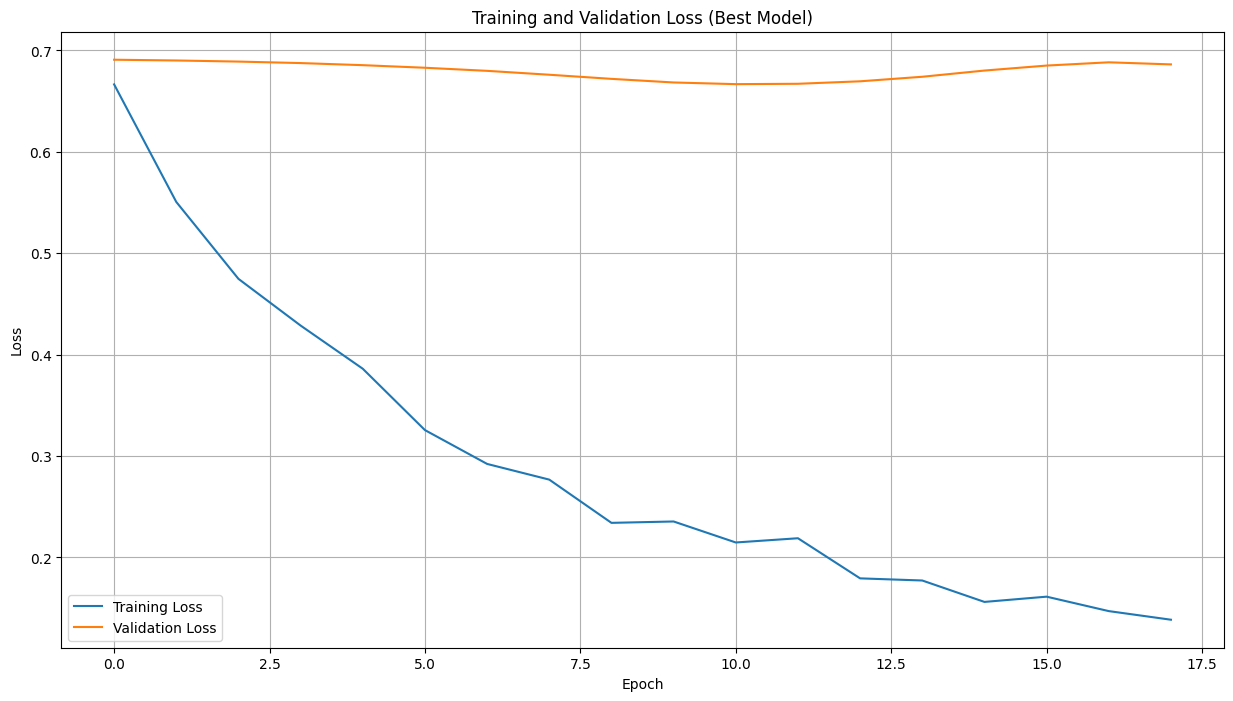

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from training.trainer import save_model



def create_data_loaders(X_train: np.ndarray, X_val: np.ndarray, X_test: np.ndarray,
                        y_train: np.ndarray, y_val: np.ndarray, y_test: np.ndarray,
                        batch_size: int = BATCH_SIZE) -> Tuple[DataLoader, DataLoader, DataLoader]:
    #Create PyTorch DataLoaders for training, validation, and testing.
    # Convert data to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    y_train_tensor = torch.LongTensor(y_train.values)
    y_val_tensor = torch.LongTensor(y_val.values)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Ensure input is 3D for LSTM: [batch, seq_len, input_size]
    if X_train_tensor.dim() == 2:
        X_train_tensor = X_train_tensor.unsqueeze(1)
    if X_val_tensor.dim() == 2:
        X_val_tensor = X_val_tensor.unsqueeze(1)
    if X_test_tensor.dim() == 2:
        X_test_tensor = X_test_tensor.unsqueeze(1)

    # Create datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader




def train_model_with_grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                                 param_grid: Dict, n_epochs: int = N_EPOCHS) -> Tuple[Dict, List[Dict]]:
    #Perform grid search to find optimal hyperparameters.
    # Create data loaders
    train_loader, val_loader, _ = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

    # Initialize tracking variables
    best_val_loss = float('inf')
    best_params = None
    results = []

    # Grid search
    for params in tqdm(ParameterGrid(param_grid)):
        # Model initialization
        model = FaceSTRNN(
            input_size=X_train.shape[1],
            hidden_size=params['hidden_size'],
            num_layers=params['num_layers'],
            num_classes=2,
            dropout=params['dropout']
        ).to(DEVICE)

        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=params['learning_rate'],
            weight_decay=params['weight_decay']
        )
        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.1,
            patience=3,
            verbose=True
        )

        # Initialize trainer 
        trainer = FaceSTRNNTrainer(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=DEVICE
        )

        # Train model 
        train_losses, val_losses = trainer.train(
            train_loader=train_loader,
            val_loader=val_loader,
            n_epochs=n_epochs
        )

        # Record results
        final_val_loss = val_losses[-1]
        results.append({
            'params': params,
            'final_val_loss': final_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        })

        # Update best parameters
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_params = params
            best_model_state = model.state_dict()
        
            # Save the best model using the save_model function
            save_model(
                model=model,
                scaler=scaler,
                input_size=X_train.shape[1],
                best_params=params,
                save_path='checkpoints/face_best_model.pth'
            )

    return best_params, results




# Train model with grid search
best_params, results = train_model_with_grid_search(X_train, y_train, X_val, y_val, PARAM_GRID)

# Print best parameters
print("\nBest parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
# print(f"Best validation loss: {best_val_loss:.4f}")

# Plot training curves for best model
plt.figure(figsize=FIGURE_SIZE)
best_result = min(results, key=lambda x: x['final_val_loss'])
plt.plot(best_result['train_losses'], label='Training Loss')
plt.plot(best_result['val_losses'], label='Validation Loss')
plt.title('Training and Validation Loss (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        61
           1       0.58      1.00      0.73        84

    accuracy                           0.58       145
   macro avg       0.29      0.50      0.37       145
weighted avg       0.34      0.58      0.42       145



/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/karlo/College/Diplomski/Code/multimodal_depression_detection/DepressionDetection/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is il

<Figure size 1500x800 with 0 Axes>

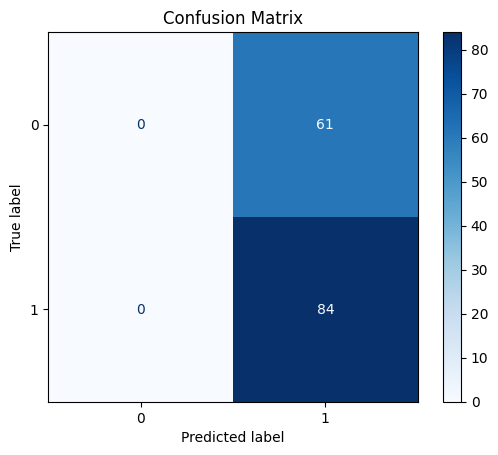

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
#     #Evaluate the model on the test set.
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for X, y in test_loader:
#             X, y = X.to(device), y.to(device)
#             outputs, _, _ = model(X)
#             _, preds = torch.max(outputs, 1)
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(y.cpu().numpy())

#     return np.array(all_labels), np.array(all_preds)


# # Create test loader
# _, _, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

# # Initialize best model
# best_model = FaceSTRNN(
#     input_size=X_train.shape[1],
#     hidden_size=best_params['hidden_size'],
#     num_layers=best_params['num_layers'],
#     num_classes=2,
#     dropout=best_params['dropout']
# ).to(DEVICE)

# # Evaluate model
# y_true, y_pred = evaluate_model(best_model, test_loader, DEVICE)

# # Print classification report
# print("Classification Report:")
# print(classification_report(y_true, y_pred))

# # Plot confusion matrix
# plt.figure(figsize=FIGURE_SIZE)
# class_labels = [0, 1]
# cm = confusion_matrix(y_true, y_pred, labels=class_labels)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.show()


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from training.trainer import load_model  # Add this import at the top of your notebook

def evaluate_model(model: nn.Module, test_loader: DataLoader, device: torch.device) -> Tuple[np.ndarray, np.ndarray]:
    """Evaluate the model on the test set."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Print prediction statistics
    probs_array = np.array(all_probs)
    print("\nPrediction Statistics:")
    print(f"Mean probability for class 0: {probs_array[:, 0].mean():.3f}")
    print(f"Mean probability for class 1: {probs_array[:, 1].mean():.3f}")
    print(f"Number of predictions for class 0: {(np.array(all_preds) == 0).sum()}")
    print(f"Number of predictions for class 1: {(np.array(all_preds) == 1).sum()}")

    return np.array(all_labels), np.array(all_preds)

# Create test loader
_, _, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test)

# Load the best model using the load_model function
best_model, _ = load_model(
    model_class=FaceSTRNN,  # Note: Changed to FaceSTRNN
    load_path='checkpoints/face_best_model.pth',
    device=DEVICE
)

# Make sure the model is in eval mode
best_model.eval()

# Evaluate model
y_true, y_pred = evaluate_model(best_model, test_loader, DEVICE)

# Print classification report with zero_division=1 to avoid warnings
print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=1))

# Plot confusion matrix
plt.figure(figsize=FIGURE_SIZE)
class_labels = [0, 1]
cm = confusion_matrix(y_true, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [10]:
# Save the model and scaler
from training.trainer import save_model

# add PARAM_GRID["num_classes"] to best_params for easy initialization during multimodal
best_params['num_classes'] = 2 
save_model(best_model, scaler, X_train.shape[1], best_params, "face_model.pth")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
